<a href="https://colab.research.google.com/github/jtwaugh/DQN/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q Learning: The Math

Let's build a deep Q network! For a recent interview, I spent three days bootstrapping one of these to prototype a learn-to-rank system, and it felt worthwhile to revisit this and really nail down the details. I've also been meaning to give myself a real project to teach myself TensorFlow, and this task seemed as good as any. In this first bit, I build a deep Q learner following the mathematical specifications, and I run it in an OpenAI gym environment.

## What is a Deep Q Network?

Great question. Let's wow you with a diagram first, because it really feels like there ought to be an immediate visual for a complicated object:

![alt text](https://imgur.com/odPWsQR.png)

Cool. The intuitive explanation is pretty simple. We have an actor who interacts with an environment, which has a state. Acting on the environment changes its state and elicits a certain reward. The goal is to maximize reward by modifying behavior. In Q learning, the program keeps track of its history, and the actor accesses the history in order to train on past events. At every step, the actor berates himself for past actions, estimating in retrospect how much reward he thinks he could have elicited in comparison to what he got, and readjusts. I find this a relatable human phenomenon, and I suspect you do, as well. 

In order to do this learning, the actor needs to keep track of both his present method and the evolving method that updates through the training process. Imagine trying to learn a new skill and being told by your mentor to "do that again the way you were doing it, so we can see what you'e doing wrong." Same deal for the actor: in order to avoid comparing an updating function against itself, we need a network to hold a frozen copy of the actor's parameters during training.

Anyway, I've separated the arrows into four types. The gold arrows indicate encapsulated behavior. In the networks, this is just TensorFlow doing neural net stuff; in the environment, this is totally unseen by the program written here and we won't pretend to know anything about it. The solid arrows represent the flow of information during the interaction process: the actor sees a state, acts, and it changes the environment and produces reward. The dashed arrows are simply the recording of historical data. The dotted arrows represent the flow of information during the learning process: the actor replays the history, computing best possible actions according to the frozen estimator, and adjusting the new parameters to gradient-descend toward the maxima from the frozen ones. Finally, the frozen parameters have to slowly update toward the new ones to keep things moving.

## Okay, But I Really Just Wanted to Know Why It's Called a 'Q' Network...

Sure. If you've done any advanced math, these sorts of names come up all the time (algebraic K theory, for instance), and you ought to know better than to ask. But if you're like me, then you still want to ask, and this time there actually is a good answer: Q is the name of the hidden function that returns the maximum reward for each action at each state, and the actor is trying to lern it. 

Let's use this as a segue into some notation.

Because we're doing reinforcement learning, our session consists of an "environment" object (in this case, the OpenAI gym) and an "actor" object represented by a neural network, and the actor will choose actions based on the observed state of the environment weighted by the speculative reward that they will produce. The map from states to actions we call the actor's *policy*. Because the network is parameterized, we can use stochastic gradient descent to try to find an optimal policy for the environment, which we take to be a satisfactory solution to the problem.

When we speak of value, of course, it's important to remember that we are in fact trying to choose a policy that creates the most *long-term* value, i.e. not naive greedy value. This matters for understanding deep Q learning. Let $R_t : s, a \mapsto r_t$ denote the reward function of the environment at time $t$, mapping a state and an action to the corresponding reward. As I mentioned, we assume no conditions on the behavior of $R$. Additionally, let $\pi: s_{t - 1} \mapsto a_t$ denote the actor's policy. Because it's parameterized by a neural net, we can speak of a compact policy space and think of our reinforcement learning problem as gradient descent in policy space. Finally, let $\gamma \in [0..1]$ be the *discount rate*, which determines the trade-off between present and future value. Now recall the Bellman equation from the machine learning literature:

$$ Q(s_0) = \max_{\pi} \sum_{t = 0}^{\infty} \gamma^t r_t$$

This states that the desirability of the environment being in some state $s_0$ is the maximum long-term reward it could yield under any policy. By "long-term reward" we mean the sum of reward values (remember $r_t = R_t(s_t, a_t)$ and $s_t$ is a (possibly nondeterministic) function of $a_{t-1}$ and $s_{t-1}$, and $a_t = \pi(s_{t-1})$.

Some pseudocode is probably instructive at this point. 

In [0]:
# General sketch of a policy iteration
# Additional code will try to improve the function actor.policy()
def pseudo_policy_iterate(env, actor, maxTime):
  actor.initialize()
  env.initialize()
  # Get s_0
  state = env.get_initial_state()
  
  for t in range(maxTime):
    # a_t = \pi(s_{t-1})
    action = actor.policy(state)
    # r_t = R_t(s, a)
    reward = env.get_reward(t, state, action)
    # a_{t-1}, s-{t-1} ->  s_t
    new_state = env.reaction(state, action)
    state = new_state
    

If the function $Q$ is known completely, and if the state resulting from each action is deterministically known, then a greedy algorithm directly yields the optimal policy, i.e. the information about the optimal policy is already in the function. However, we know neither the full reward function nor do we know how to reach one state from another by means of a certain action. As it turns out, a greedy algorithm will remain optimal in most practical cases, but this is merely an empirical fact. In light of the unknowns, we really want to investigate a different, but related, function:

$$ Q_{\pi}(s, a) = \mathbb{E}\left[ \sum_{t = 0}^{\infty} \gamma^t r_t \mid s_0 = s, a_0 = a, a_t = \pi(s_{t-1}) \right] $$

That is, we suppose we have partial information about the best policy given an action on a certain present state and we set our actor to work trying to estimate a policy that approaches the value $Q_*(s, a) = \max_{\pi} Q_{\pi}(s, a)$ at each state $s$ and each action $a$.

There you have it: it's a deep neural net that's trying to efficiently approximate $Q_*$ in order to determine an optimal policy in a given environment.

## Defining the Loss Function with Respect to Historical Data

Great, so how do we define a loss function that gets us there? Obviously there's no guarantee of a global maximum, so we have to choose some sort of compromise that will converge us to a good estimate with reasonable resources. 

What's distinctive about deep Q learning is that the actor "introspects" after every action: the program keeps a "subject history" of the actor, which will get minibatch-sampled at every step to readjust the actor network against a new estimate of the maximum-value policy. The idea here is to continually re-estimate our long-term rewards given new information from the environment. That is, we want to figure out the best the actor "could have done" given all of its present information, then compare the current policy to the estimated ideal performance. Let $\hat{Q}(s, a, \theta)$ denote the actor network's estimate of $Q(s, a)$ at parameters $\theta$. We define the *time-difference (TD) error* as follows:

$$\delta(t) = | r_t + \gamma \cdot \max_{a_{t+1}} \hat{Q}(s_{t+1}, a_{t+1}, \theta^{-})  - \hat{Q}(s, a, \theta)  | $$

Here $\theta^-$ denotes the parameters present in the actor network at the beginning of the training, copied into the target network and updating very slowly toward $\theta$ throughout the session. On the other hand, $ \theta$ will update ate every step $t$ as in standard gradient descent.

Thinking about this more deeply for a second, we see that it's really two terms. The first is real reward plus dsicounted speculative target estimate, and the second is actor estimate. What happens when this discrepancy is large is that the actor's parameters readjust quickly "in the direction of the first value." That is, the full expression correctly describes an attempt to approximate $Q_*$ at each $s$ and $a$. 


In [0]:
def pseudo_replay_learn(actor, history, gamma):
  # Freeze our estimator parameters
  target_params = copy(actor.parameters)
  # Learn over many iterations
  for epsiode in range(max_episodes):
    loss = 0.0
    for event in history:
      (state, action, reward, time, newState) = event
      # Compute \hat{Q}(s_{t+1}, a_{t+1}, \theta^-)
      action_values = [ actor.estimate(newState, newAction, target_params)\
                        for newAction in actor.actions ]
      # Get our new estimate
      new_estimate = actor.estimate(state, action, actor.parameters)
      # Get our TD error
      delta = (reward + gamma * max(action_values) - new_estimate)
      # Update our MSE
      loss += delta**2
    # Adjust our estimate weights each episode
    actor.update_weights(error)

## The Environment and Exploration/Exploitation

Let's put this together, with one final concern.

Notice that below I include a chance of acting randomly: this is called an $\varepsilon$*-greedy algorithm* and it's an attempted answer to the problem of *exploration-exploitation* tradeoff. This is a pretty easy concern to visualize, especially in light of the performance this code initially elicits. 

Here's the MountainCar environment that I deploy the network in:

![alt text](http://gym.openai.com/v2018-02-21/videos/MountainCar-v0-270f34b9-f23e-4d95-a933-4c902b4f4435/poster.jpg)

The environment simulates Newtonian mechanics in two dimensions, and you can see from your own physical intuition how the actor can win. The reward is -1.0 for every frame at which the cart is not sitting at the flag, the the environment terminates as soon as the cart touches the flag. Therefore, the optimal policy gets the cart to the top as quickly as possible.

How will the deep Q learner find this policy? Imagine we've been sitting for one hundred frames and trying to learn on past experiences. Having not yet seen a successful policy, the learner will not be maximiing toward anything meaningful. In fact, naively learning like this prevents us from ever succeeding. What's to be done?

There's a problem called the [multi-armed bandit](https://en.wikipedia.org/wiki/Multi-armed_bandit) and it lies in that class of problems with stupid-sounding names that you just can't aviod hearing mention of when you study the field to which they pertain. It describes essentially the predicament we're about to get into: it's clear that the actor needs to behave randomly sometimes in order to have anything other than past experience to learn on. In other words, in order to avoid local minima of $\hat{Q}_{\theta}$ over the parameter space, we have to *explore* it a bit. However, exploring too much will make the actor unable to actually pursue a single policy and at worst give rise to random motion with no learning. That is, it does need to keep *exploiting* the value it finds through exploration.

How do we trade off? Well, the solution to the multi-armed bandit problem, which I am appropriating here without really thinking about it, is the $\varepsilon$-greedy method. Every step, with probability $p = (1 - \varepsilon) + \varepsilon / |A|$ for $A$ the set of possible actions, the actor follows his intuition. Otherwise, he performs a random action.

This will hopefully be good enough for now, as it promises that the actor is at least not guaranteed to get stuck.

In [0]:
# General sketch of a policy iteration
# Additional code will try to improve the function actor.policy()
def pseudo_train(env, actor, gamma, max_time):
  # Start the history
  history = []
  # Start the black boxes
  actor.initialize()
  env.initialize()
  # Get s_0
  state = env.get_initial_state()
  
  for t in range(max_time):
    # a_t = \pi(s_{t-1}) with Pr = (1 - \epsilon) + (\epsilon/|A|)
    action = -1
    if random.random() > (1 - epsilon) + (epsilon / actor.actions_num):
        action = random_action()
    else:
        action = actor.policy(state)
    # r_t = R_t(s, a)
    reward = env.get_reward(t, state, action)
    # a_{t-1}, s-{t-1} ->  s_t
    new_state = env.reaction(state, action)
    # Memorize
    history.append((state, action, reward, time, newState))
    # Replay the memory bank and learn
    pseudo_replay_learn(env, actor, gamma)
    # Advance in time
    state = new_state

Of course, we have to tune a number of hyperparameters here. And, of course, in reality we're not going to read the entire history every time but rather minibatch-sample it. And we probably only want to train every several time steps. And we want a max size on the history. But the effect is the same: we're trying to efficiently estimate at each step the total divergence from the best forseeable performance at that step, and then backpropagate the actor network. 

Following the seminal paper by Mnih et al. (2015), we can write the minibatch loss function, letting $U(D)$ denote a uniform distribution over the history as

$$ \mathcal{L}_i(\theta_i) = \mathbb{E}_{(s, a, r, s') \ \sim \ U(D)} \left[ \left( r + \max_{a'} \hat{Q}(s', a', \theta_i^-) - \hat{Q}(s, a, \theta_i) \right)^2 \right] $$

Now that the main routine is clear enough that we're worrying about implementation concerns like the above, let's actually take a look at the working Python code.

# Deep Q Learning: The Code

Okay, now bear with me through some setup stuff on the Google machine.

In [4]:
!apt-get install swig
!pip3 install gym
!pip3 install Box2D
!pip3 install box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 3 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 2s (444 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpacking sw

And the relevant imports:

In [0]:
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, BatchNormalization, Activation

import numpy as np

from collections import deque

import random

Let's set a print flag so we can debug:

In [0]:
debug_print = False

And here's the class that implements the "History" object. Notice that I use a double-ended queue for efficiency, and that it helps to automatically handle the tupling and untupling of stored events. The function ``sample()`` returns numpy arrays ready for TensorFlow to use.

In [0]:
# Stores tuples of (state, action, reward, time, new_state)
class Buffer:

    def __init__(self, cap=1000, seed=1728):
        random.seed(seed)
        self.buffer = deque()
        self.count = 0
        self.cap = cap

    def append(self, s, a, r, t, s2):
        unit = (s, a, r, t, s2)
        # Make sure to respect the max capacity
        if self.count < self.cap: 
            self.buffer.append(unit)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(unit)

    def sample(self, batch_size):
        # Get events
        batch = random.sample(self.buffer, min([self.count, batch_size]))
        # Print if flagged
        if debug_print:
            print("Sampled ", batch_size, " events from the buffer.")
        # Now collate the events
        # Concatenate here because they're shape (1, state_dims)
        s_batch = np.concatenate([s for (s, a, r, t, s2) in batch])
        # Reshape here because we need a second dimension
        a_batch = np.reshape([a for (s, a, r, t, s2) in batch], (batch_size, 1))
        r_batch = np.reshape([r for (s, a, r, t, s2) in batch], (batch_size, 1))
        t_batch = np.reshape([t for (s, a, r, t, s2) in batch], (batch_size, 1))
        # Concatenate here because they're shape (1, state_dims)
        s2_batch = np.concatenate([s2 for (s, a, r, t, s2) in batch])
        return s_batch, a_batch, r_batch, t_batch, s2_batch

Next, we'll build an actual deep Q network. As alluded to above, when we freeze the parameters $\theta^-$, we're better off just keeping an entire other network, christened the *target network*. To do this, then, we include a function to build these both. 

Additionally, we're going to have to custom-define the loss function with its own computation graph, since (to my knowledge) TensorFlow does not include a built-in Q-learning module. (It's also a good exercise.) This is part of the beauty of TensorFlow. Here's a sketch I made of what's going on. The gold boxes represent placeholder Tensor objects with no defined size, whereas the grey boxes represent batches of size ``batch_size``. Considering only the graph on the gold boxes allows us to define a "flow" for the tensors that's represented totally abstractly. Nowhere in defining the loss function do I call ``session.run()``, because the function is just a graph.

![alt text](https://imgur.com/ntxZhOk.png)
 
We can see the flow between the two networks, although the actual mathematics is now obscured. When we use the object ``self.loss``, the whole depicted apparatus of circular nodes and their edges is what we're working with. It was working through how to set this up that finally made the meaning of the term "TensorFlow" finally click for me.

In fact, this is the only effective way to do this. If we remember how backpropagation works, the only way to actually learn is to adjust each parameter in each network according to the loss function's gradient with respect to that parameter. The only way that we can get TensorFlow to compute all those gradients for us is to define the loss function as a graph. That is, had we not done it this way, the loss function wouldn't be TensorFlow-differentiable and we'd be hosed. However, this way, training is now straightforward. Just take the optimizer that we're accustomed to using and tell it to minimize the custom loss function. I define a ``train`` function as a wrapper, but as you can see, all it does is run the provided session on the loss function mimizer.

In [0]:
class Actor:

    def __init__(self, state_dims, actions_num, hidden_size,\
                 learning_rate, tau):
        # Network parameters
        self.state_dims = state_dims
        self.actions_num = actions_num
        self.hidden_size = hidden_size
        # Hyperparameters
        self.learning_rate = learning_rate
        # Learning rate for target network
        self.tau = tau

        with tf.name_scope('actor'):
            # Assemble the actor
            self.actor_input, self.actor_network = self.build_nn()
            self.actor_params = tf.trainable_variables()
            # Might want to normalize these
            self.actor_gradients = tf.gradients(self.actor_network,\
                                                self.actor_params)
            # Get the optimizer involved
            self.opt = tf.train.AdamOptimizer(self.learning_rate)

        with tf.name_scope('target'):
            # Assemble the target network - this freezes params for training
            self.target_input, self.target_network = self.build_nn()
            self.target_params = tf.trainable_variables()\
                                  [len(self.actor_params):]
            # We might want to normalize these
            self.target_gradients = tf.gradients(self.target_network,\
                                             self.target_params)

        # Have the target parameters slowly catch up to the actor parameters
        self.update_target = [ self.target_params[i].assign(\
            tf.multiply(self.actor_params[i], self.tau) +
            tf.multiply(self.target_params[i], 1. - self.tau))\
            for i in range(len(self.target_params)) ]

        with tf.name_scope('loss'):
            # Placeholders for the batch values
            self.loss_actions = tf.placeholder(tf.int32, shape=(None, 1))
            self.loss_rewards = tf.placeholder(tf.float32, shape=(None, 1))

            # Build the graph for the loss function
            target_rewards = self.loss_rewards + \
                              tf.reduce_max(self.target_network, axis=1)
            estimates = tf.batch_gather(self.actor_network, self.loss_actions)
            td_error = target_rewards - estimates
            self.loss = tf.reduce_mean(tf.square(td_error))
            # Visualize the loss function
            self.loss_placeholder = tf.placeholder(tf.int32, shape=())
            self.loss_summary = tf.summary.scalar('loss', self.loss_placeholder)
        
        # Operation for updating the actor network's weights
        self.update_actor = self.opt.minimize(self.loss,\
                                              var_list=self.actor_params)
        
    # Encapsulate this because we're going to call it twice
    def build_nn(self):
        inputLayer = tf.placeholder(tf.float32, shape=(None, self.state_dims))
        hiddenLayer = Dense(self.hidden_size)
        # The network is trying to estimate the value for each possible action
        outputLayer = Dense(self.actions_num)
        # And put them all together
        layers = BatchNormalization()(inputLayer)
        layers = Activation('relu')(layers)
        layers = hiddenLayer(layers)
        layers = BatchNormalization()(layers)
        layers = Activation('relu')(layers)
        layers = outputLayer(layers)
        layers = Activation('softmax')(layers)
        # We have to return the input layer to give it data
        return inputLayer, layers
    
    # Predict on a numpy array
    # Should return an integer for the action number
    def predict(self, session, inputs):
        return session.run(self.actor_network,\
                           feed_dict={ self.actor_input : inputs } )

    # Push the minibatch to the loss function minimizer
    # Return the loss so we can plot
    def train(self, session, s_batch, a_batch, r_batch, s2_batch):
        sess_loss, _ = session.run( [self.loss, self.update_actor],\
                                  feed_dict = { self.actor_input : s_batch,\
                                                self.loss_actions : a_batch,\
                                                self.loss_rewards : r_batch,\
                                                self.target_input : s2_batch } )
        return sess_loss
        

There's a lot going on up there. The ``build_nn`` function just puts together a deep net with one hidden layer, and it has to return both the input and output layers so that we can pipe in the batches from the history buffer. We have to keep track of the actor and target parameters so that we can update the target parameters slowly.

In [0]:
# Training routine within a TF session
# TODO log the reward values for TensorBoard
def train(session, env, actor,\
          epsilon=0.10, ep_num=1000, ep_length=1000, minibatch_size=64):
    env.reset()
    # Keep the buffer here
    history = Buffer()
    # Update target network parameters
    session.run(actor.update_target)
    # Start running episodes
    for ep in range(ep_num):
        # Print
        print("EPISODE ", ep)
        # Per episode, reset the environment
        state = env.reset()
        ep_reward = 0
        ep_avg_max = 0
        ep_losses = []
        ep_pos = []
        ep_vel = []
        # Run through the epochs
        for epoch in range(ep_length):
            
            # Get the most favored action given the actor's prediction
            state_vec = np.reshape(state, (1, actor.state_dims))
            # Record position and velocity
            ep_pos.append(state[0])
            ep_vel.append(state[1])
            
            # Get the action as the index in the distribution
            # But we want to do this epsilon-greedily or else get stuck
            action = -1
            if random.random() > (1 - epsilon) + (epsilon / actor.actions_num):
                action = random.randint(0, actor.actions_num - 1)
            else:
                action = np.argmax(actor.predict(session, state_vec))
            
            # Print if flagged
            if debug_print:
                print("Performed action ", action)
            
            # Feed this into the gym environment
            new_state, reward, done, info = env.step(action)
            
            # Print if flagged
            if debug_print:
                print("Got reward ", reward)
                print("Resulted in state ", new_state)
            
            # If the actor won or died or whatever it is, break the loop
            if done:
                # Print if flagged
                if debug_print:
                    print("Terminated.")
                break
                
            # Store the results as a tuple
            history.append( state_vec, action, reward, done, \
                            np.reshape(new_state, (1, actor.state_dims)) )
            
            # If we're large enough, take a minibatch sample and train the net
            if history.count > minibatch_size:
                # Get the arrays corresponding to the values
                s_batch, a_batch, r_batch, t_batch, s2_batch =\
                 history.sample(minibatch_size)
                # Feed this to the DQN to train
                ep_losses.append( actor.train( session, 
                                               s_batch, 
                                               a_batch, 
                                               r_batch, 
                                               s2_batch) )
                
            
            # Update the state
            state = new_state
            # Tabulate reward
            ep_reward += reward
            # The paper claims we do this in here
            # Let the target parameters crawl toward the actor parameters
            session.run(actor.update_target)
        # Print
        print("Mean batch loss per epoch:")
        plt.ylim(0.5, 1.5)
        plt.plot(ep_losses)
        plt.show()
        print("Cart position per epoch:")
        # Height function stolen from MountainCar source code
        plt.xlim(-1.2,0.6)
        plt.ylim(0.0, 1.0)
        plt.scatter(ep_pos, [np.sin(3 * x)*.45+.55 for x in ep_pos], c=(range(200)), cmap=plt.cm.autumn)
        plt.show()
        #print("Cart velocity per epoch:")
        #plt.plot(ep_vel)
        #plt.show()
        print("Total reward: ", ep_reward, "\n-----------")

And we're ready to go. We can run this on an OpenAI gym environment and watch the magic happen!

In [0]:
def main():
    with tf.Session() as session:
        # Import the environment
        env = gym.make('MountainCar-v0')
        # Seed the RNG
        np.random.seed(1)
        tf.set_random_seed(1)
        # Set hyperparameters
        state_dims = env.observation_space.shape[0]
        actions_num = env.action_space.n
        hidden_size = 32
        learning_rate = 0.001
        tau = 0.1
        # Build the actor
        actor = Actor(state_dims, actions_num, hidden_size, learning_rate, tau)
        # Get going
        print("Training beginning")
        session.run(tf.global_variables_initializer())
        train(session, env, actor)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training beginning
EPISODE  0
Mean batch loss per epoch:


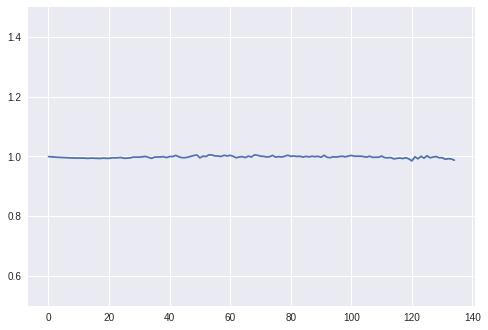

Cart position per epoch:


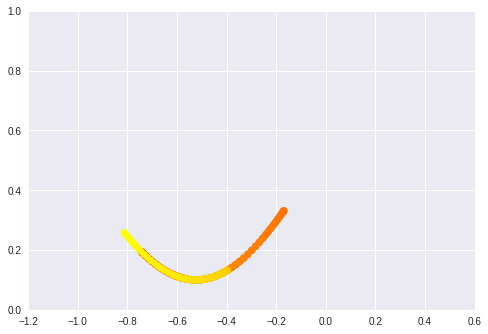

Total reward:  -199.0 
-----------
EPISODE  1
Mean batch loss per epoch:


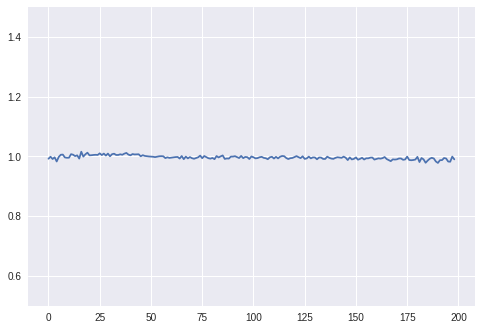

Cart position per epoch:


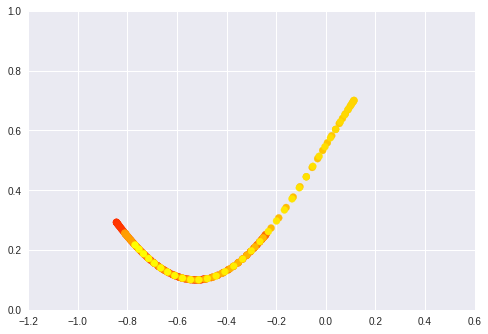

Total reward:  -199.0 
-----------
EPISODE  2
Mean batch loss per epoch:


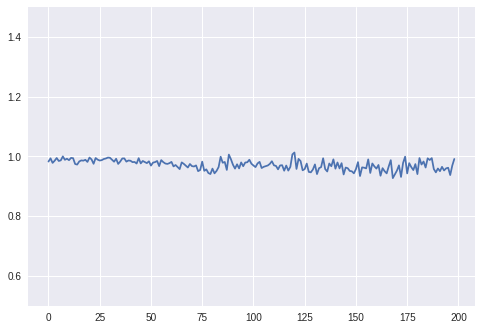

Cart position per epoch:


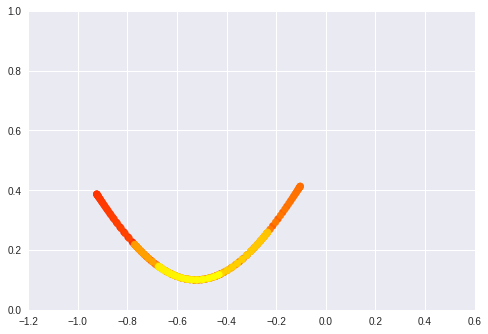

Total reward:  -199.0 
-----------
EPISODE  3
Mean batch loss per epoch:


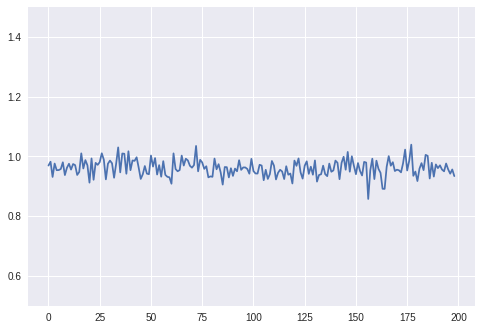

Cart position per epoch:


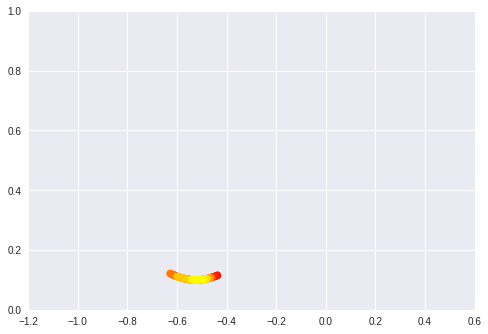

Total reward:  -199.0 
-----------
EPISODE  4
Mean batch loss per epoch:


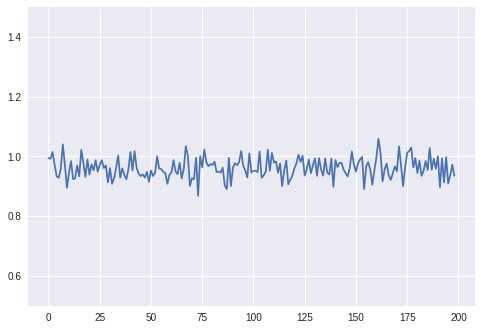

Cart position per epoch:


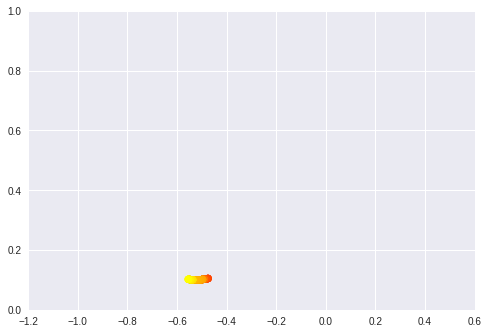

Total reward:  -199.0 
-----------
EPISODE  5
Mean batch loss per epoch:


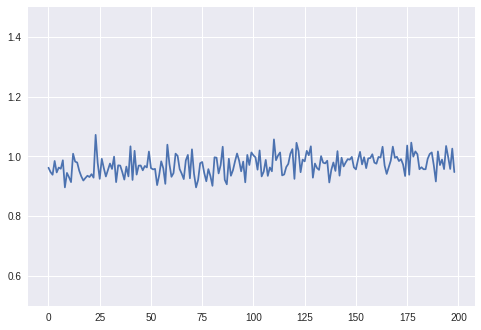

Cart position per epoch:


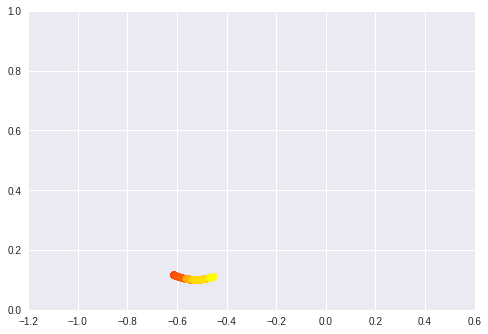

Total reward:  -199.0 
-----------
EPISODE  6
Mean batch loss per epoch:


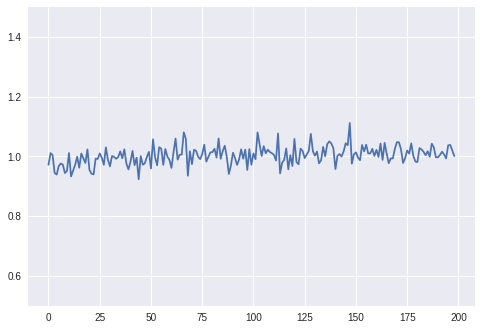

Cart position per epoch:


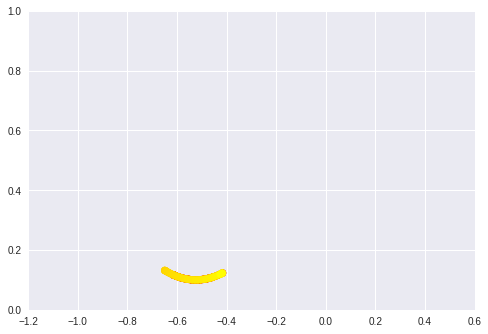

Total reward:  -199.0 
-----------
EPISODE  7
Mean batch loss per epoch:


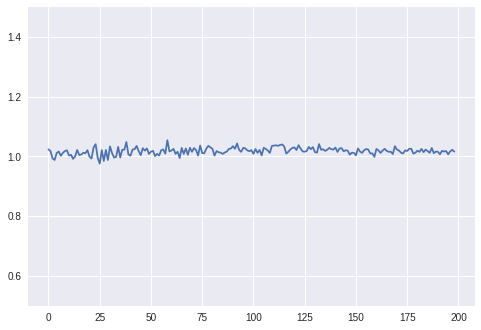

Cart position per epoch:


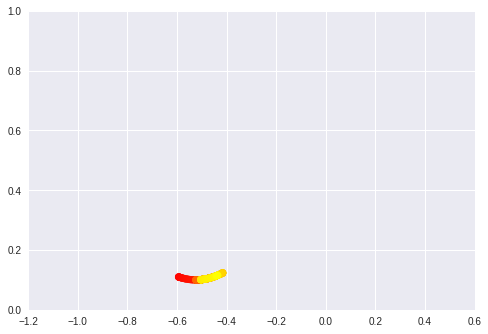

Total reward:  -199.0 
-----------
EPISODE  8
Mean batch loss per epoch:


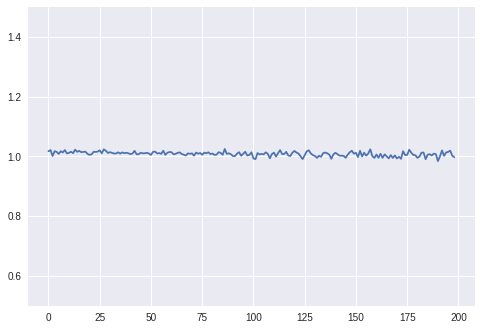

Cart position per epoch:


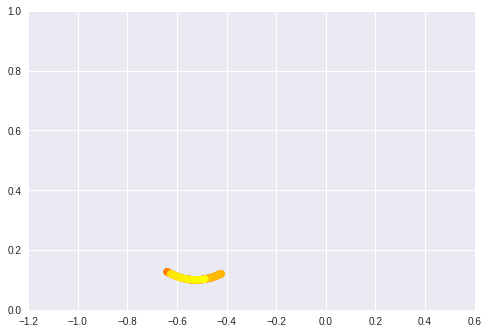

Total reward:  -199.0 
-----------
EPISODE  9
Mean batch loss per epoch:


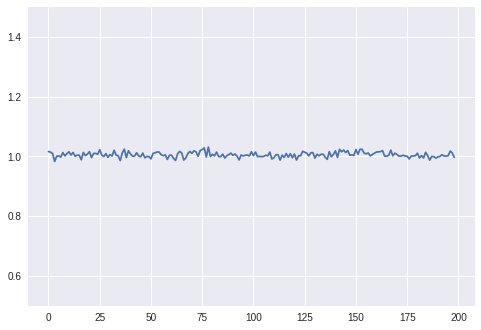

Cart position per epoch:


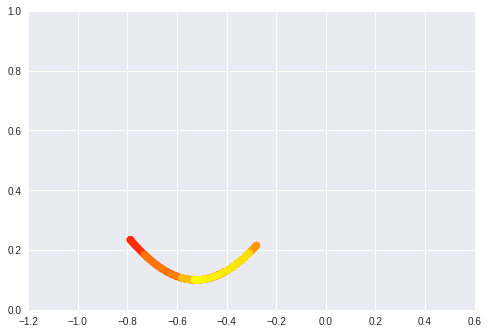

Total reward:  -199.0 
-----------
EPISODE  10
Mean batch loss per epoch:


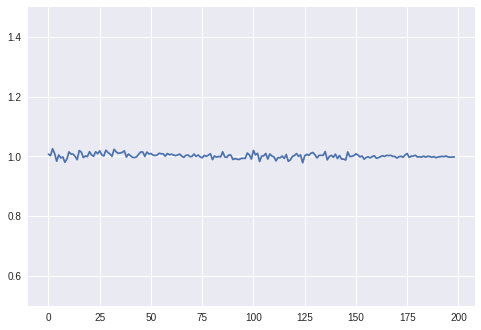

Cart position per epoch:


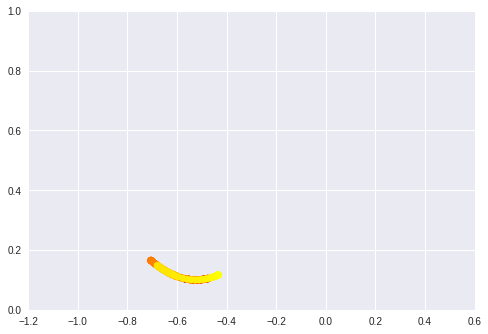

Total reward:  -199.0 
-----------
EPISODE  11
Mean batch loss per epoch:


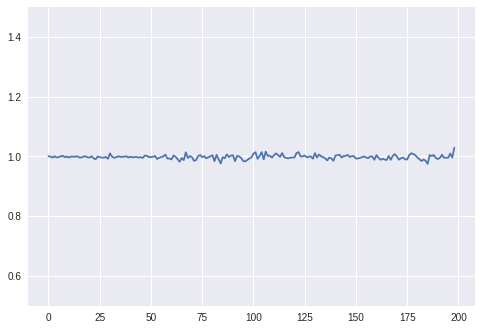

Cart position per epoch:


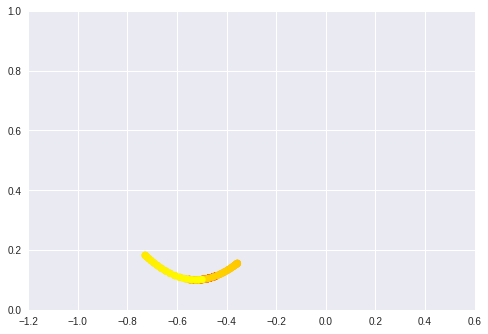

Total reward:  -199.0 
-----------
EPISODE  12
Mean batch loss per epoch:


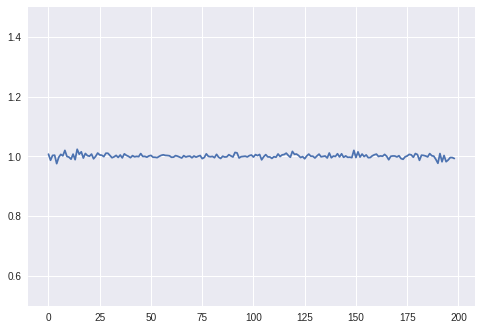

Cart position per epoch:


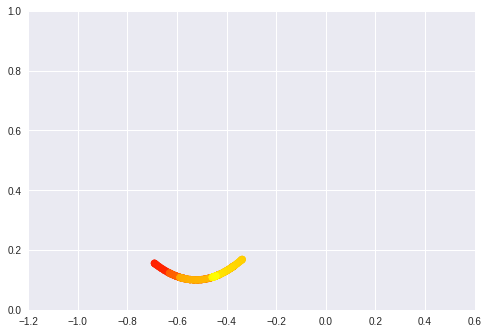

Total reward:  -199.0 
-----------
EPISODE  13
Mean batch loss per epoch:


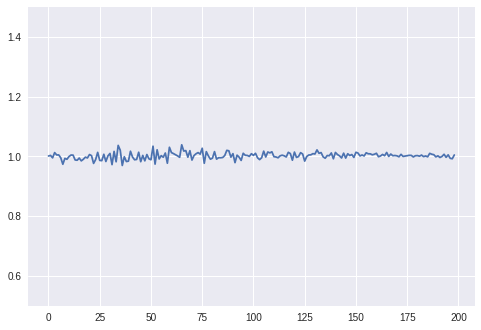

Cart position per epoch:


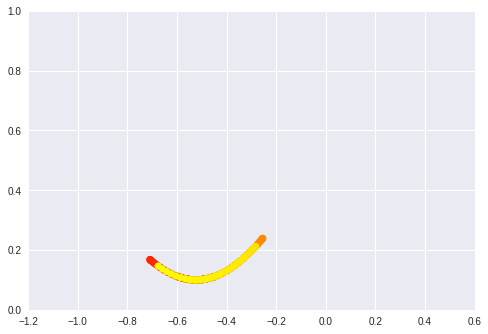

Total reward:  -199.0 
-----------
EPISODE  14
Mean batch loss per epoch:


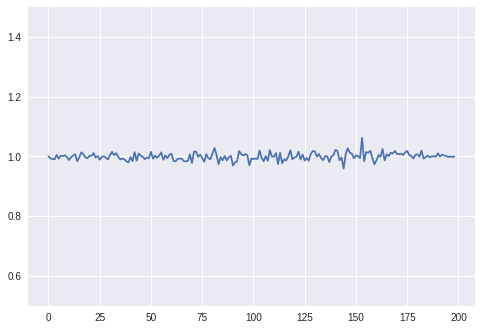

Cart position per epoch:


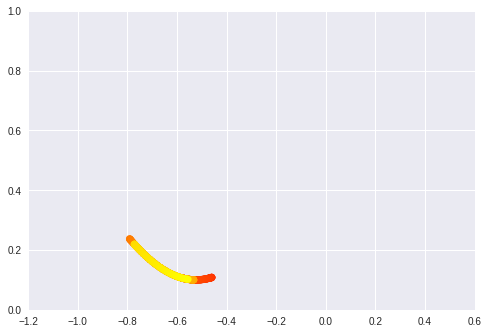

Total reward:  -199.0 
-----------
EPISODE  15
Mean batch loss per epoch:


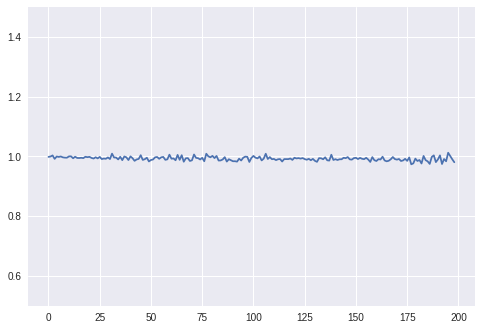

Cart position per epoch:


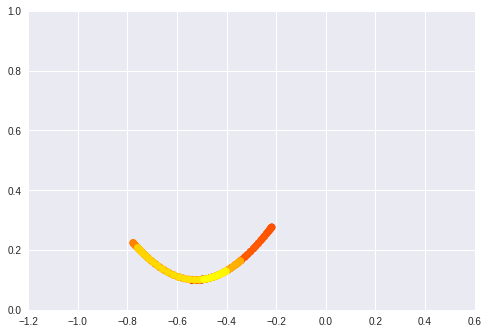

Total reward:  -199.0 
-----------
EPISODE  16
Mean batch loss per epoch:


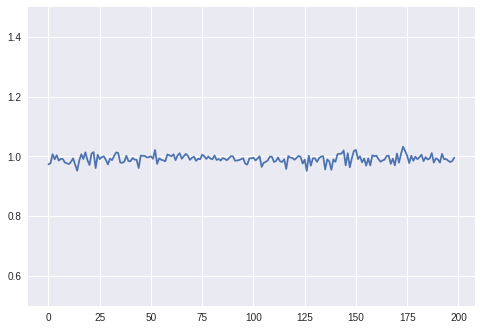

Cart position per epoch:


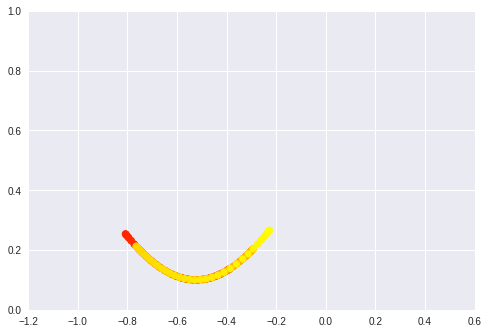

Total reward:  -199.0 
-----------
EPISODE  17
Mean batch loss per epoch:


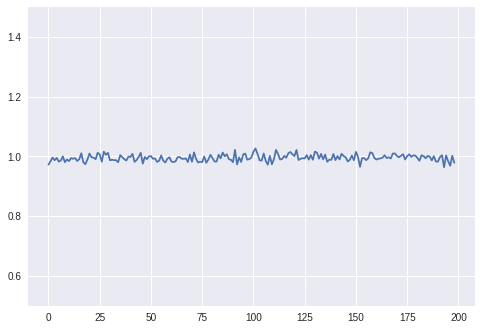

Cart position per epoch:


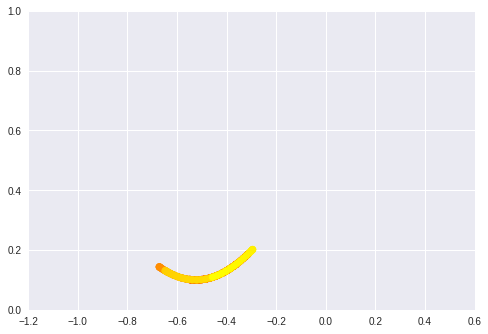

Total reward:  -199.0 
-----------
EPISODE  18
Mean batch loss per epoch:


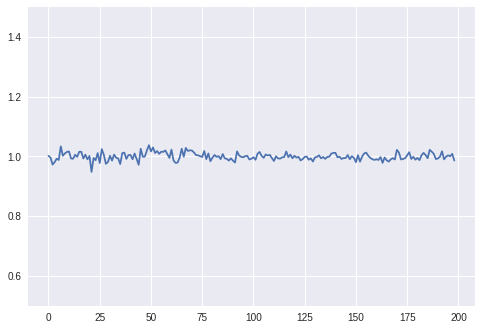

Cart position per epoch:


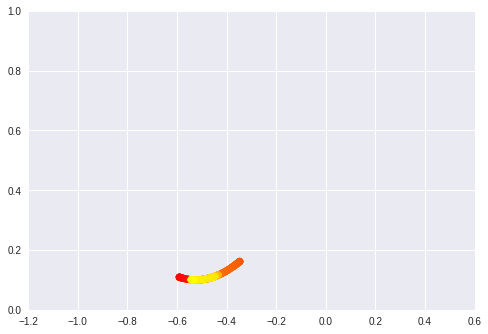

Total reward:  -199.0 
-----------
EPISODE  19
Mean batch loss per epoch:


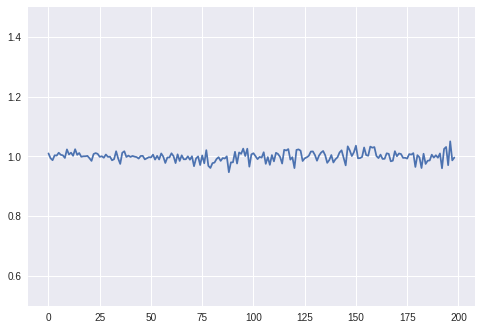

Cart position per epoch:


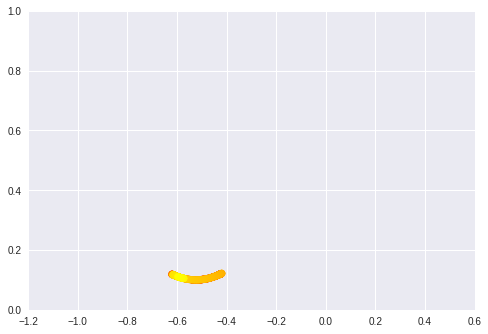

Total reward:  -199.0 
-----------
EPISODE  20
Mean batch loss per epoch:


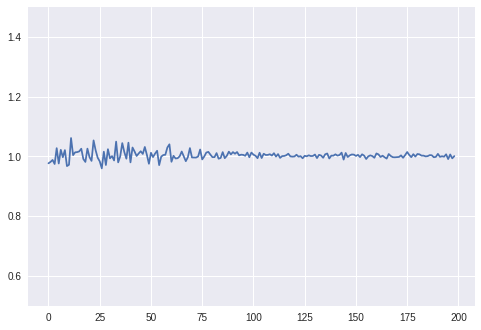

Cart position per epoch:


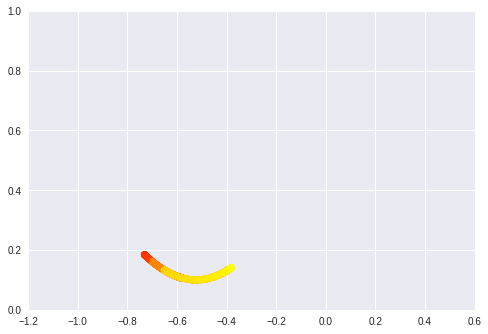

Total reward:  -199.0 
-----------
EPISODE  21
Mean batch loss per epoch:


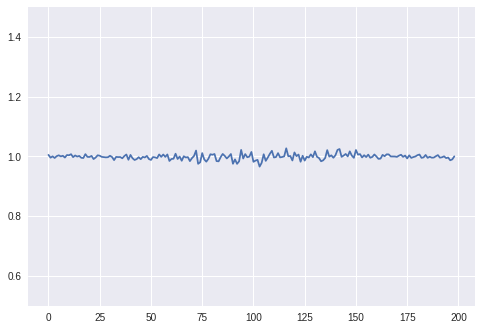

Cart position per epoch:


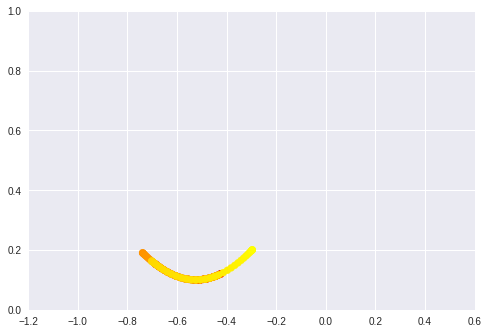

Total reward:  -199.0 
-----------
EPISODE  22
Mean batch loss per epoch:


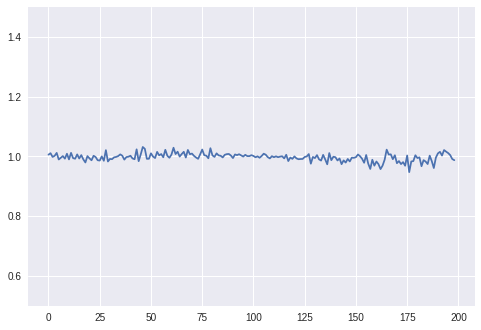

Cart position per epoch:


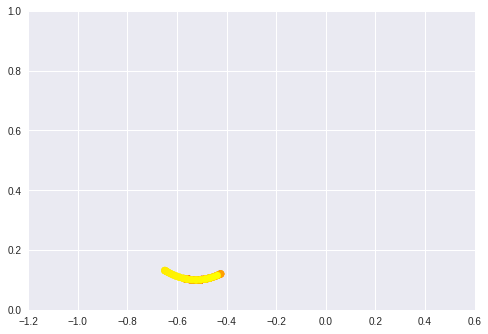

Total reward:  -199.0 
-----------
EPISODE  23
Mean batch loss per epoch:


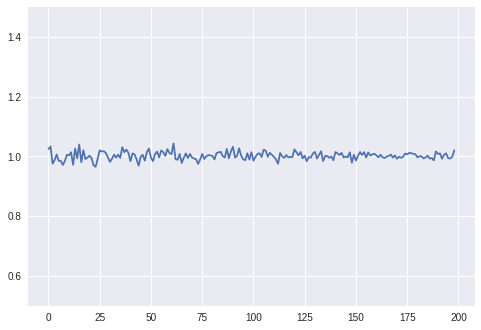

Cart position per epoch:


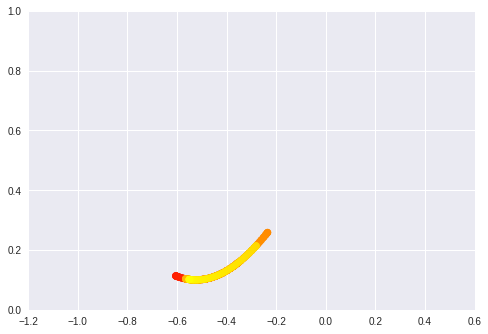

Total reward:  -199.0 
-----------
EPISODE  24
Mean batch loss per epoch:


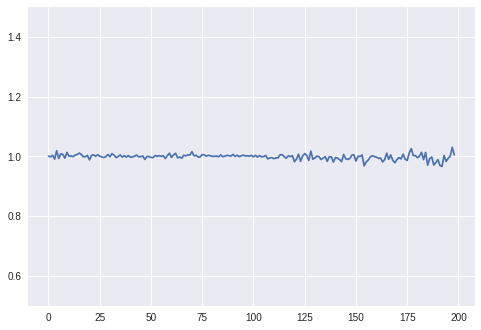

Cart position per epoch:


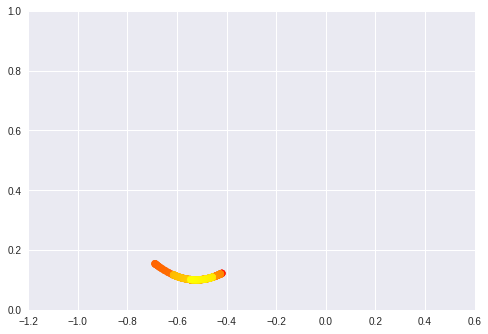

Total reward:  -199.0 
-----------
EPISODE  25
Mean batch loss per epoch:


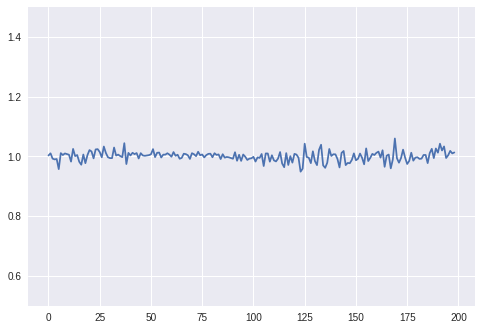

Cart position per epoch:


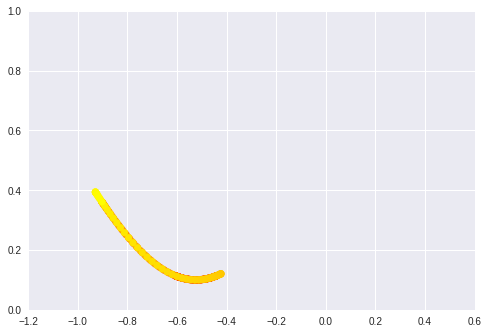

Total reward:  -199.0 
-----------
EPISODE  26
Mean batch loss per epoch:


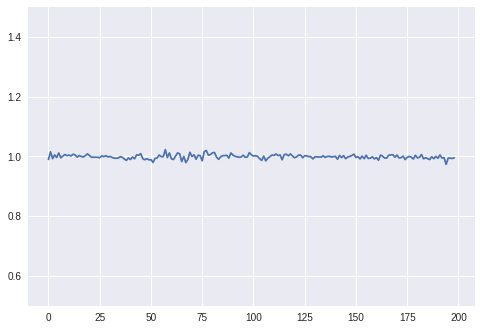

Cart position per epoch:


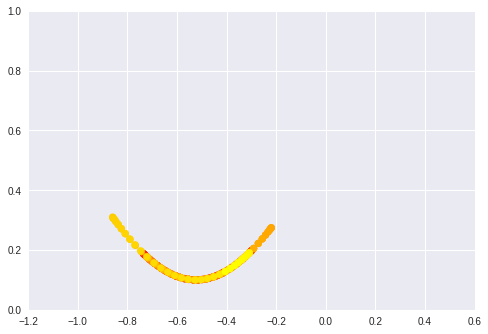

Total reward:  -199.0 
-----------
EPISODE  27
Mean batch loss per epoch:


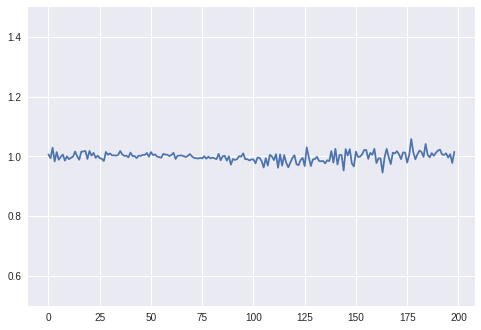

Cart position per epoch:


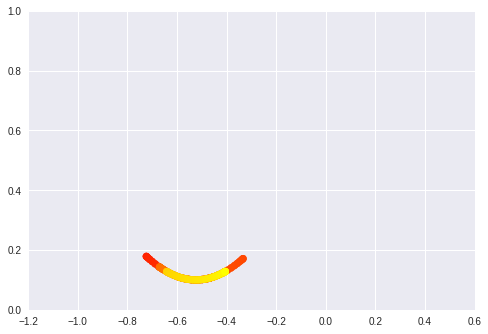

Total reward:  -199.0 
-----------
EPISODE  28
Mean batch loss per epoch:


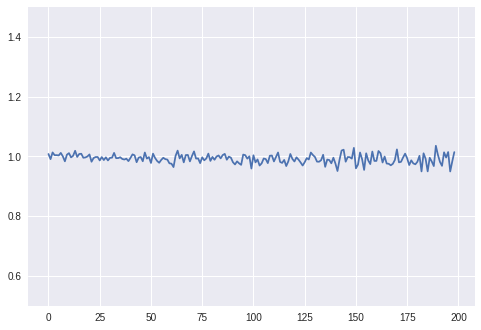

Cart position per epoch:


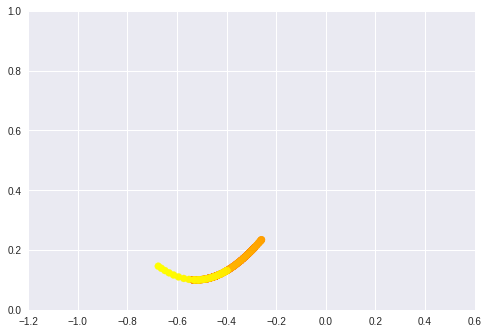

Total reward:  -199.0 
-----------
EPISODE  29
Mean batch loss per epoch:


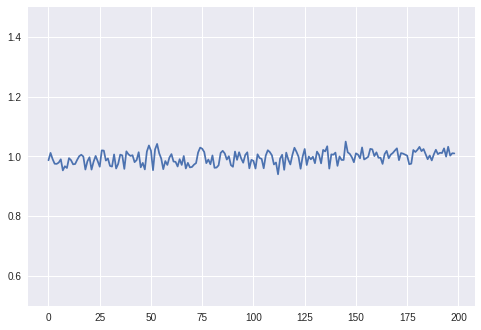

Cart position per epoch:


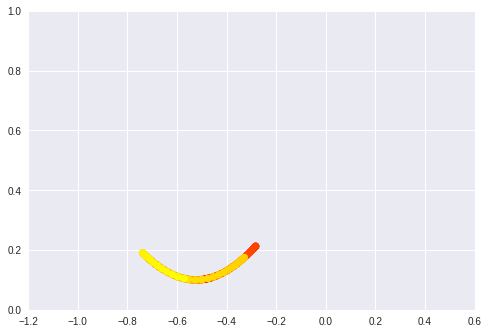

Total reward:  -199.0 
-----------
EPISODE  30
Mean batch loss per epoch:


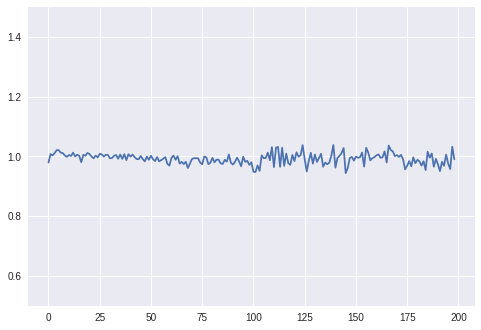

Cart position per epoch:


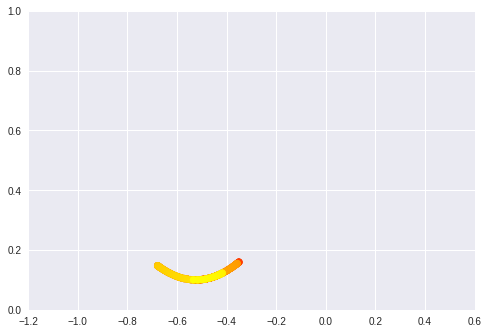

Total reward:  -199.0 
-----------
EPISODE  31
Mean batch loss per epoch:


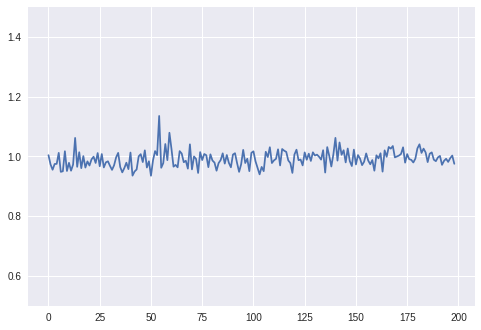

Cart position per epoch:


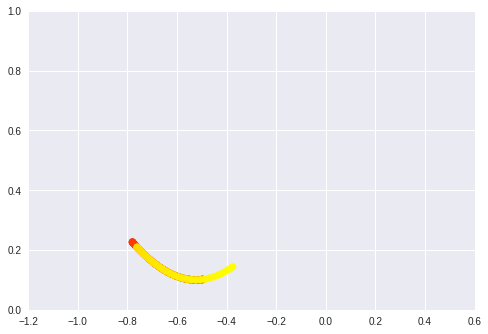

Total reward:  -199.0 
-----------
EPISODE  32
Mean batch loss per epoch:


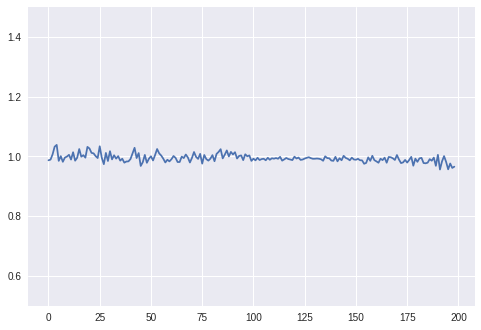

Cart position per epoch:


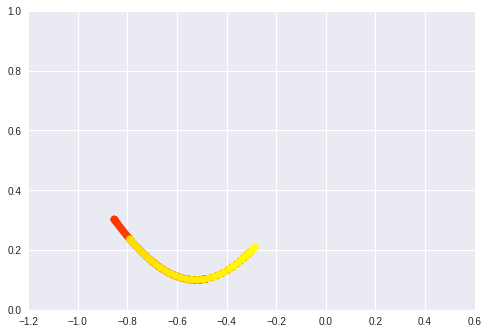

Total reward:  -199.0 
-----------
EPISODE  33
Mean batch loss per epoch:


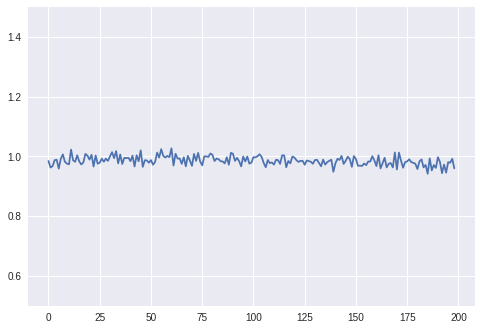

Cart position per epoch:


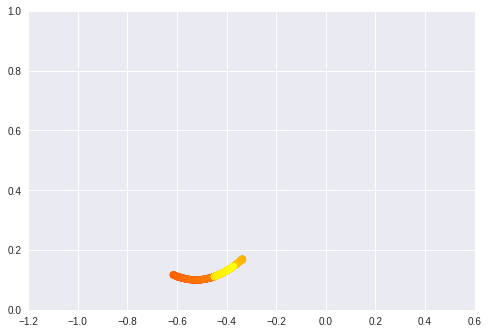

Total reward:  -199.0 
-----------
EPISODE  34
Mean batch loss per epoch:


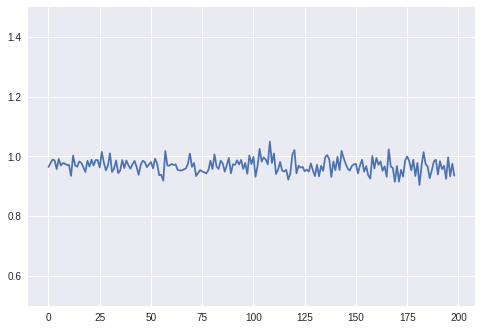

Cart position per epoch:


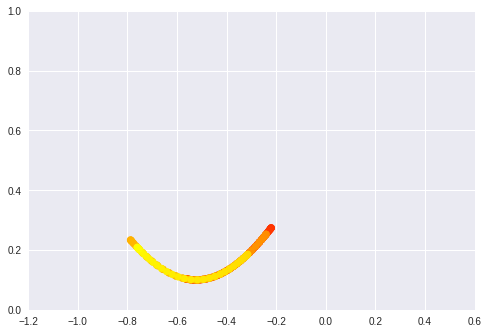

Total reward:  -199.0 
-----------
EPISODE  35
Mean batch loss per epoch:


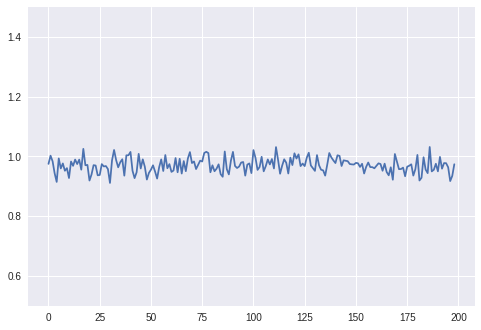

Cart position per epoch:


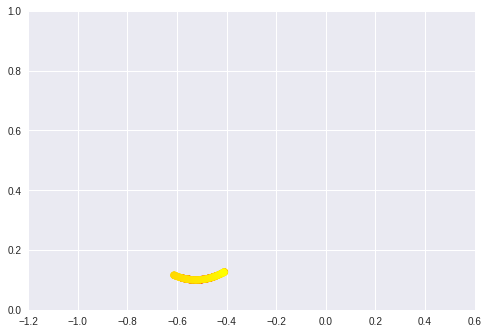

Total reward:  -199.0 
-----------
EPISODE  36
Mean batch loss per epoch:


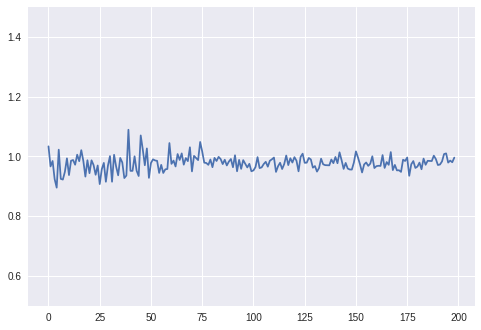

Cart position per epoch:


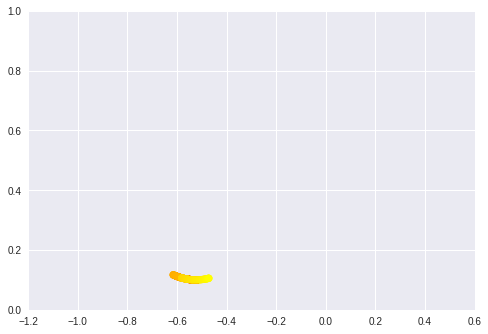

Total reward:  -199.0 
-----------
EPISODE  37
Mean batch loss per epoch:


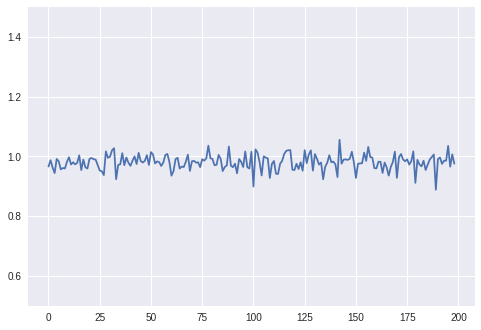

Cart position per epoch:


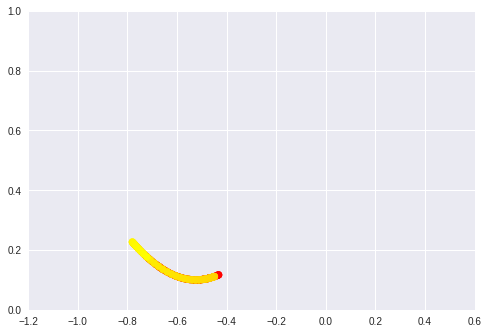

Total reward:  -199.0 
-----------
EPISODE  38
Mean batch loss per epoch:


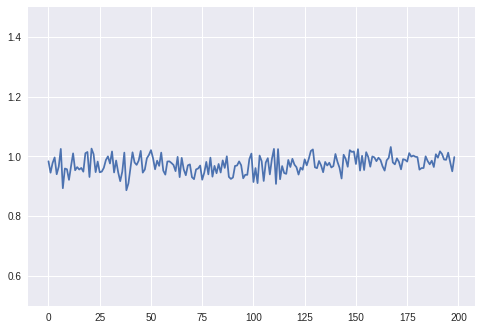

Cart position per epoch:


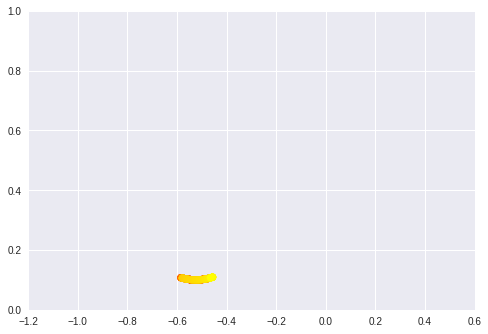

Total reward:  -199.0 
-----------
EPISODE  39
Mean batch loss per epoch:


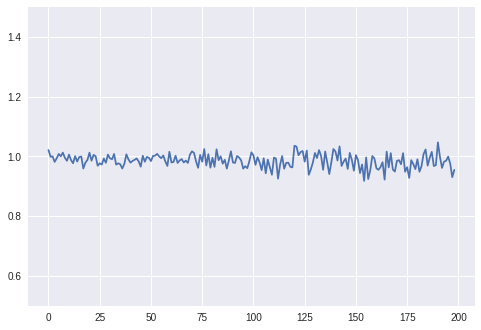

Cart position per epoch:


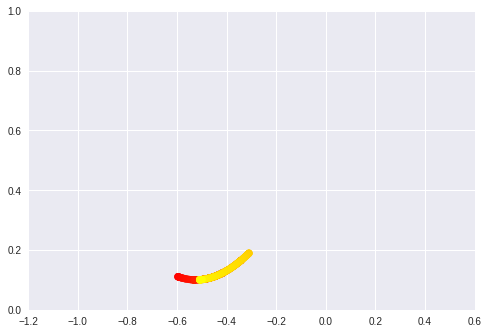

Total reward:  -199.0 
-----------
EPISODE  40
Mean batch loss per epoch:


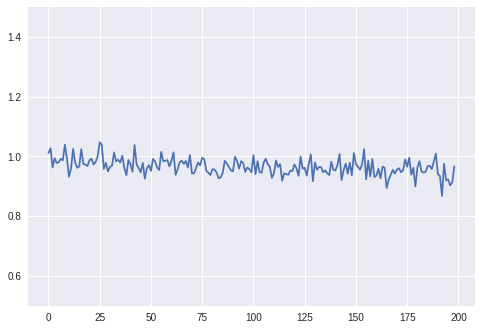

Cart position per epoch:


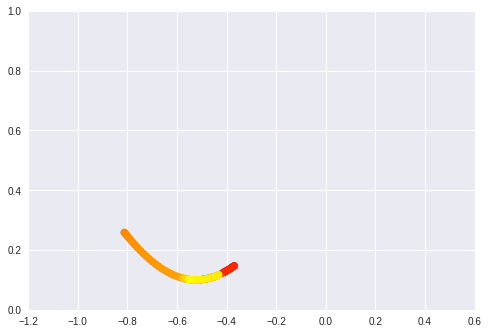

Total reward:  -199.0 
-----------
EPISODE  41
Mean batch loss per epoch:


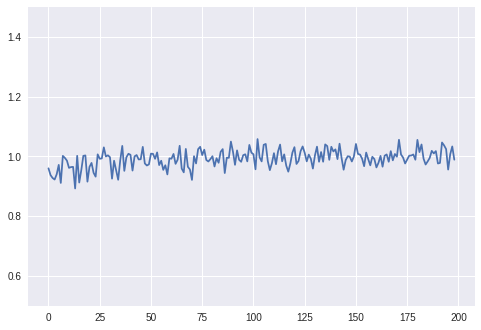

Cart position per epoch:


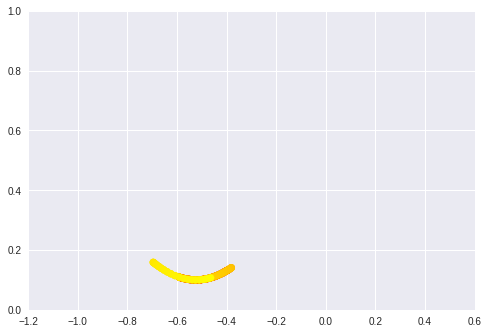

Total reward:  -199.0 
-----------
EPISODE  42
Mean batch loss per epoch:


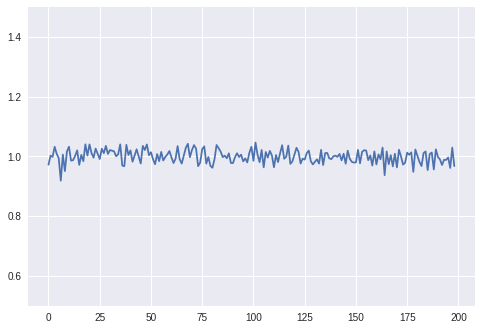

Cart position per epoch:


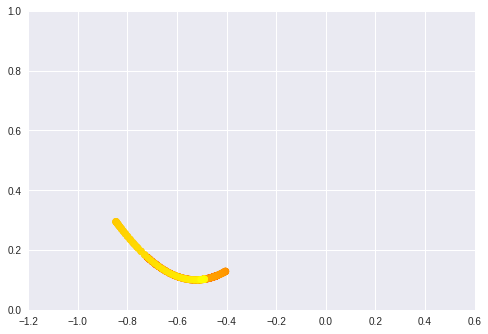

Total reward:  -199.0 
-----------
EPISODE  43
Mean batch loss per epoch:


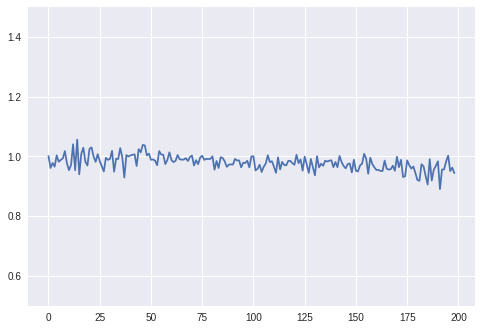

Cart position per epoch:


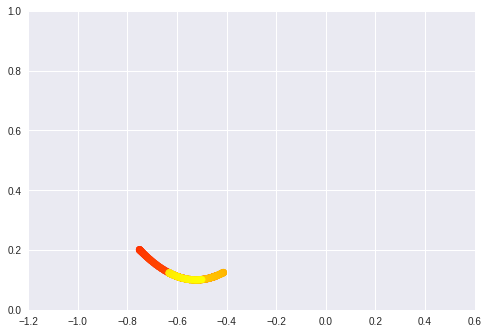

Total reward:  -199.0 
-----------
EPISODE  44
Mean batch loss per epoch:


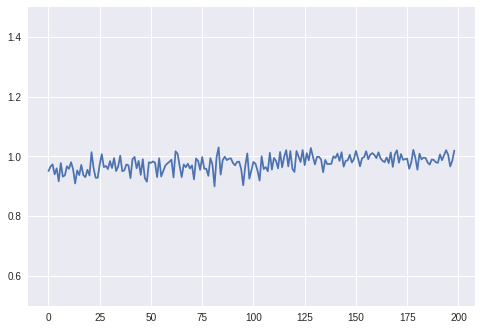

Cart position per epoch:


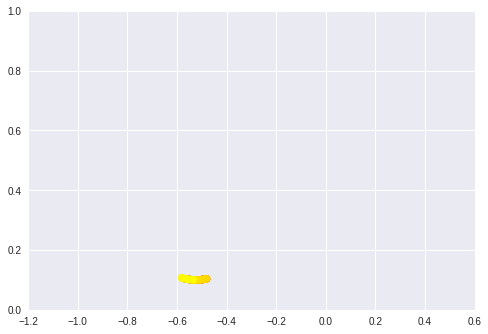

Total reward:  -199.0 
-----------
EPISODE  45
Mean batch loss per epoch:


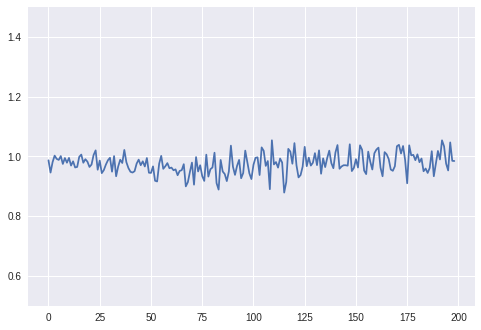

Cart position per epoch:


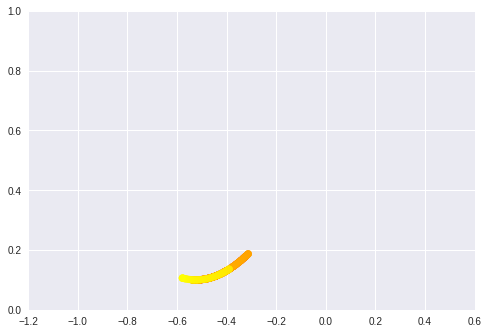

Total reward:  -199.0 
-----------
EPISODE  46
Mean batch loss per epoch:


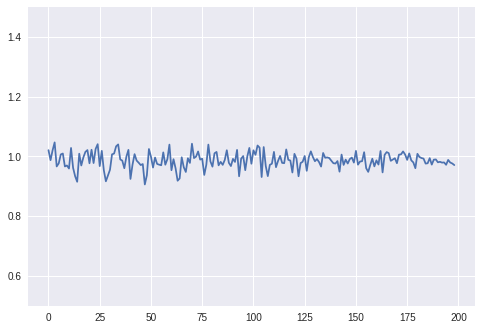

Cart position per epoch:


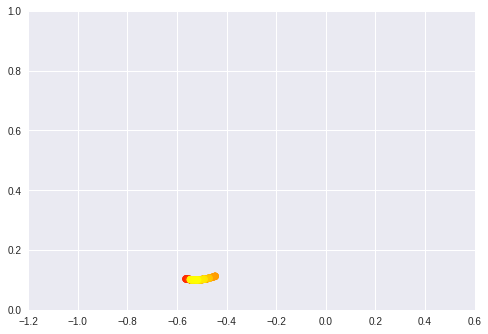

Total reward:  -199.0 
-----------
EPISODE  47
Mean batch loss per epoch:


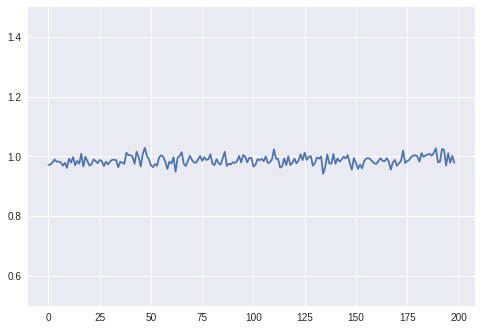

Cart position per epoch:


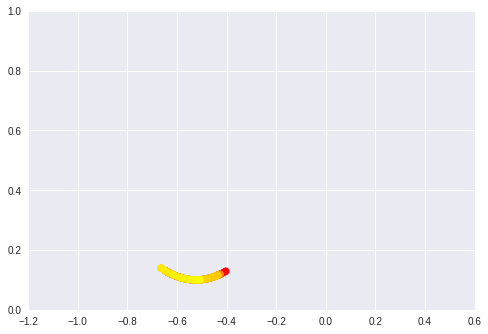

Total reward:  -199.0 
-----------
EPISODE  48
Mean batch loss per epoch:


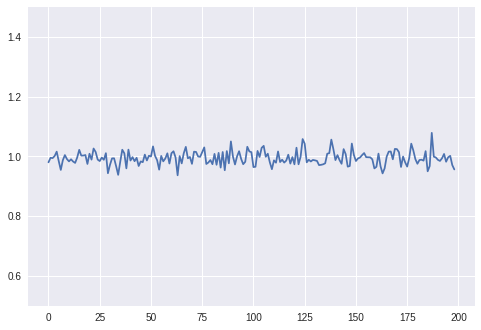

Cart position per epoch:


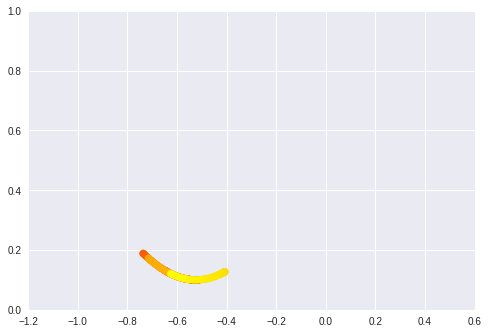

Total reward:  -199.0 
-----------
EPISODE  49
Mean batch loss per epoch:


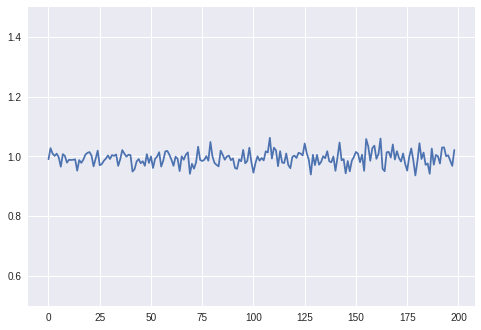

Cart position per epoch:


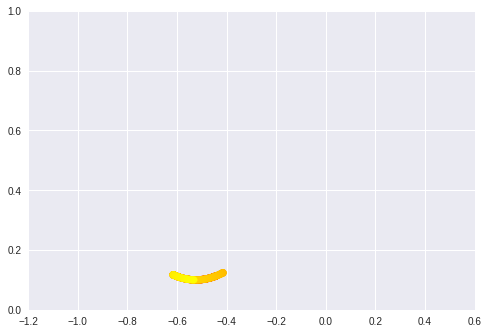

Total reward:  -199.0 
-----------
EPISODE  50
Mean batch loss per epoch:


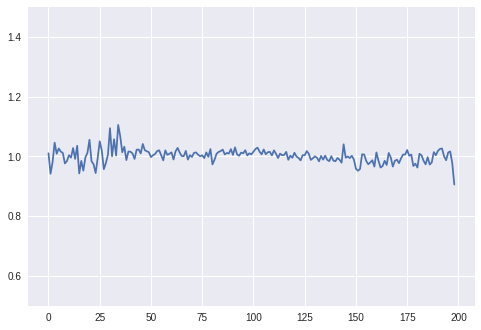

Cart position per epoch:


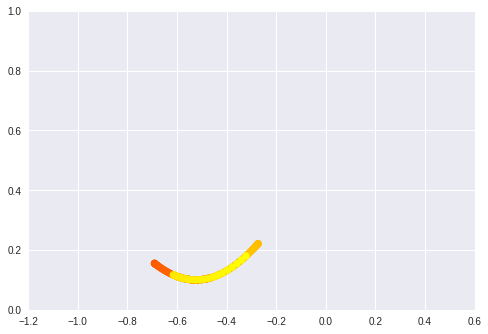

Total reward:  -199.0 
-----------
EPISODE  51
Mean batch loss per epoch:


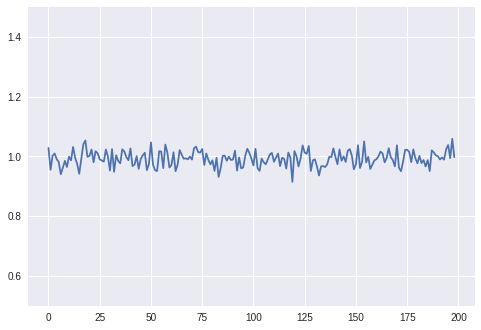

Cart position per epoch:


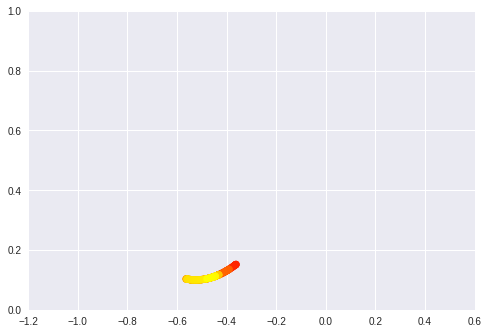

Total reward:  -199.0 
-----------
EPISODE  52
Mean batch loss per epoch:


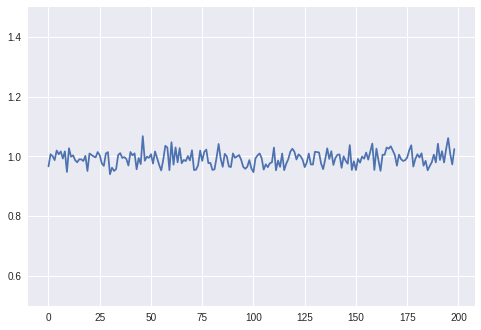

Cart position per epoch:


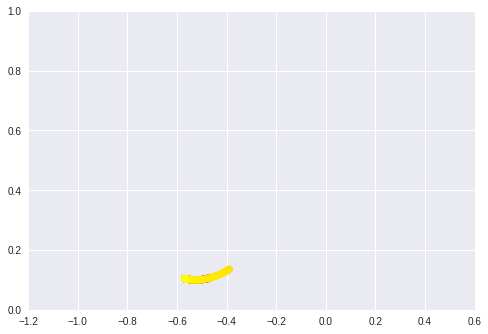

Total reward:  -199.0 
-----------
EPISODE  53
Mean batch loss per epoch:


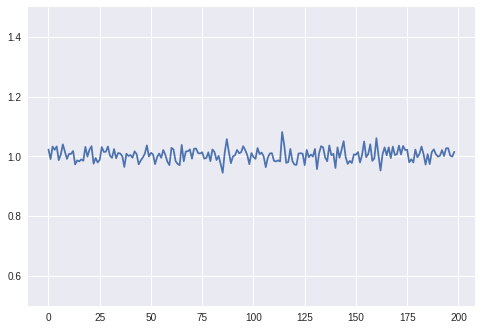

Cart position per epoch:


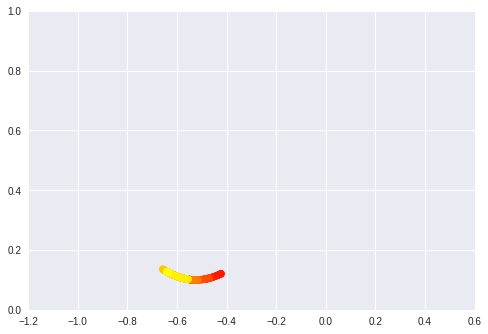

Total reward:  -199.0 
-----------
EPISODE  54
Mean batch loss per epoch:


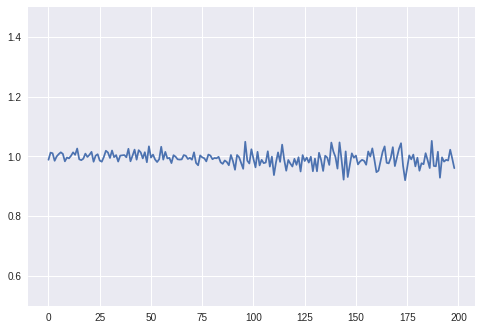

Cart position per epoch:


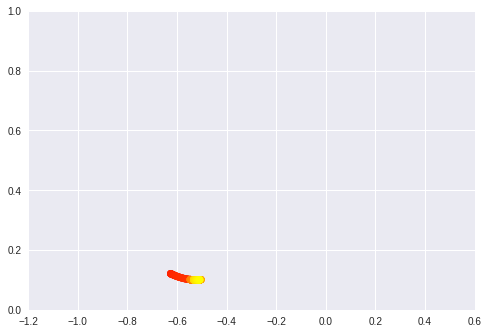

Total reward:  -199.0 
-----------
EPISODE  55
Mean batch loss per epoch:


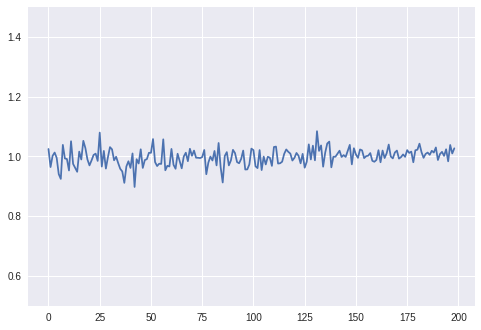

Cart position per epoch:


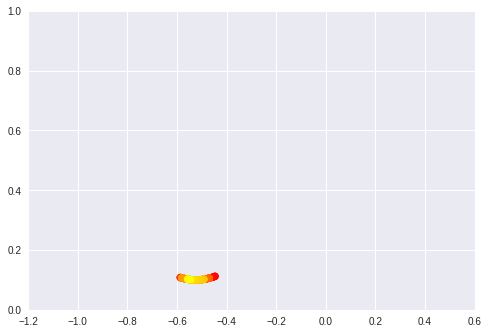

Total reward:  -199.0 
-----------
EPISODE  56
Mean batch loss per epoch:


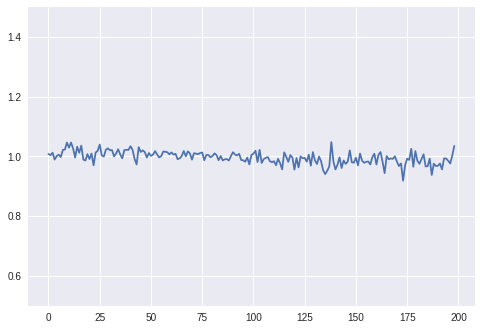

Cart position per epoch:


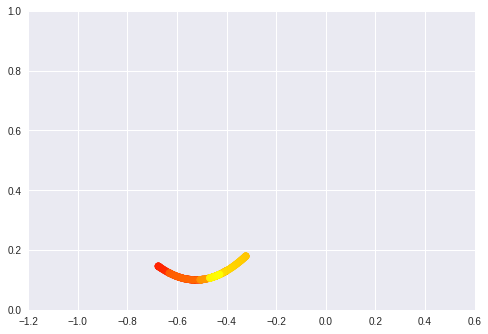

Total reward:  -199.0 
-----------
EPISODE  57
Mean batch loss per epoch:


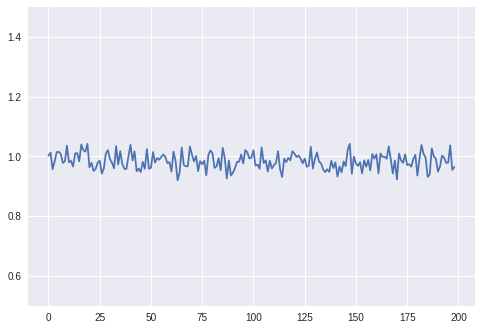

Cart position per epoch:


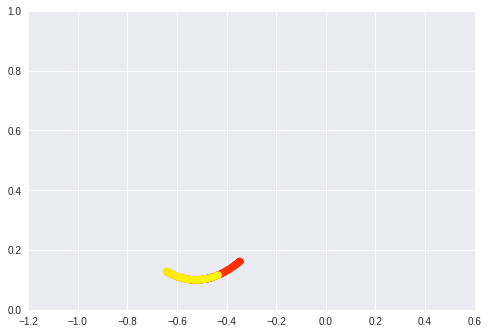

Total reward:  -199.0 
-----------
EPISODE  58
Mean batch loss per epoch:


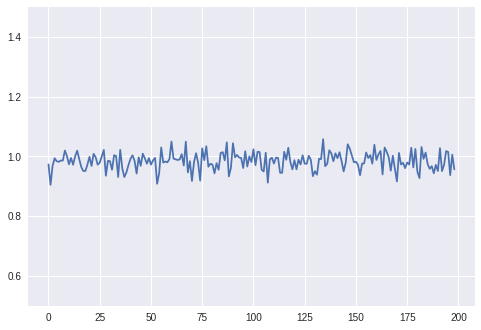

Cart position per epoch:


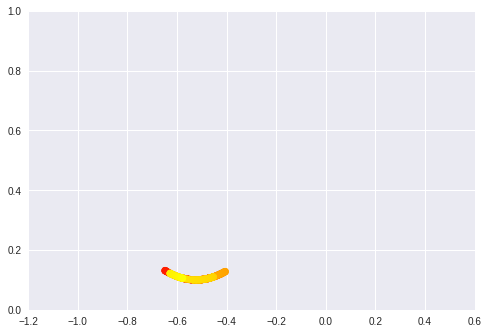

Total reward:  -199.0 
-----------
EPISODE  59
Mean batch loss per epoch:


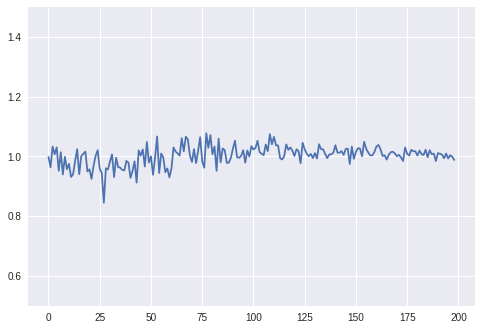

Cart position per epoch:


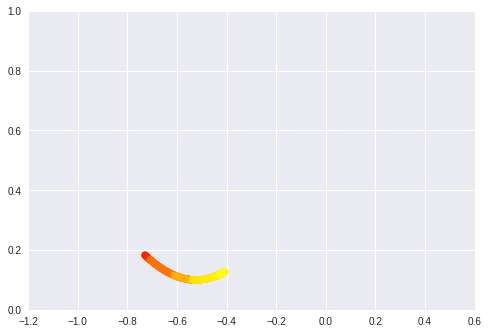

Total reward:  -199.0 
-----------
EPISODE  60
Mean batch loss per epoch:


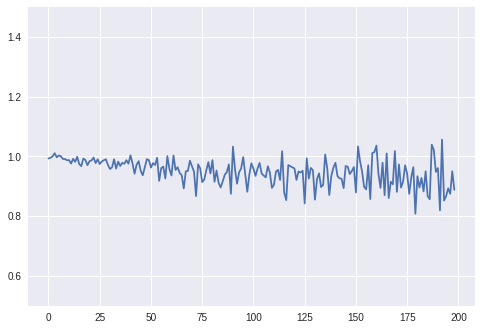

Cart position per epoch:


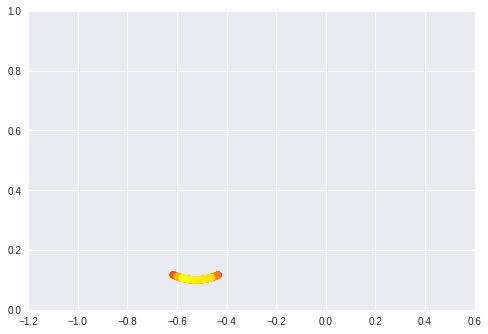

Total reward:  -199.0 
-----------
EPISODE  61
Mean batch loss per epoch:


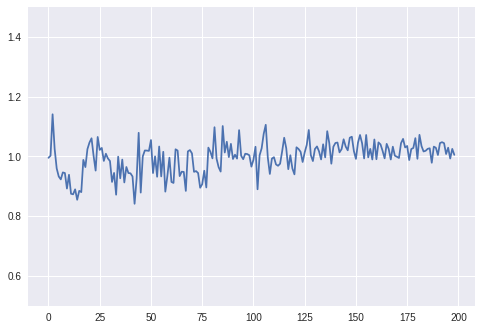

Cart position per epoch:


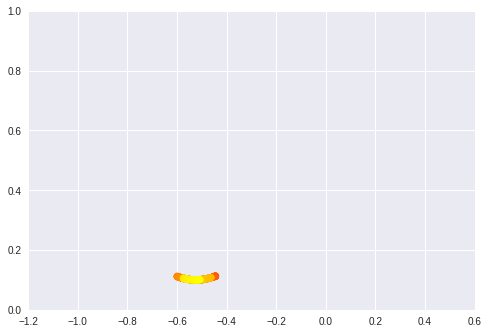

Total reward:  -199.0 
-----------
EPISODE  62
Mean batch loss per epoch:


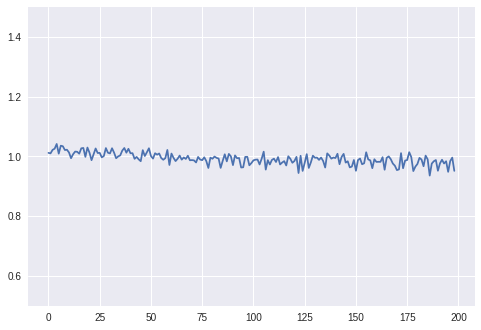

Cart position per epoch:


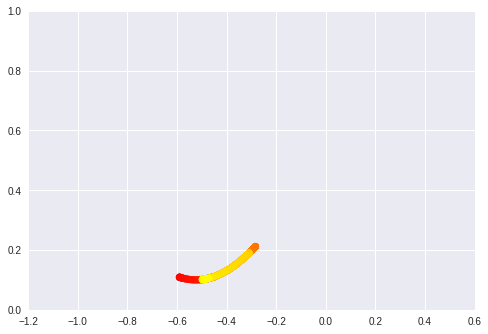

Total reward:  -199.0 
-----------
EPISODE  63
Mean batch loss per epoch:


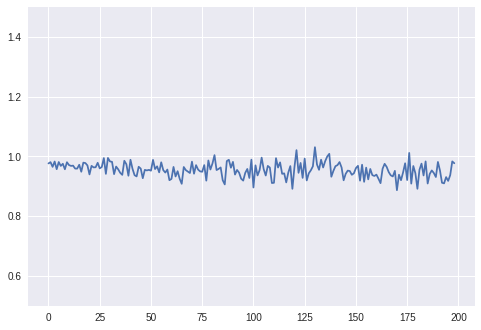

Cart position per epoch:


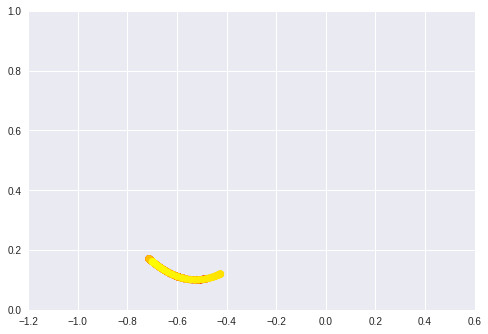

Total reward:  -199.0 
-----------
EPISODE  64
Mean batch loss per epoch:


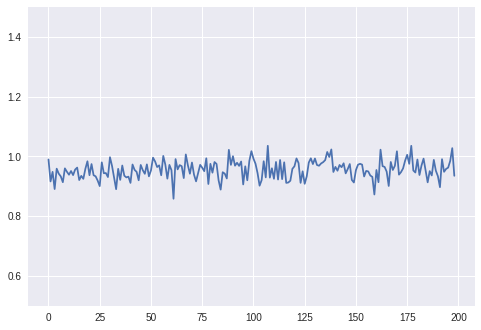

Cart position per epoch:


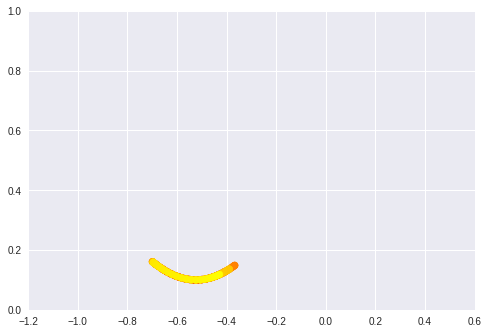

Total reward:  -199.0 
-----------
EPISODE  65
Mean batch loss per epoch:


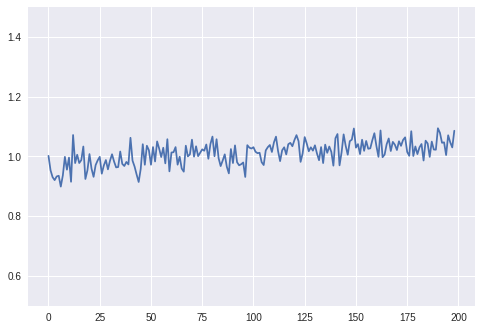

Cart position per epoch:


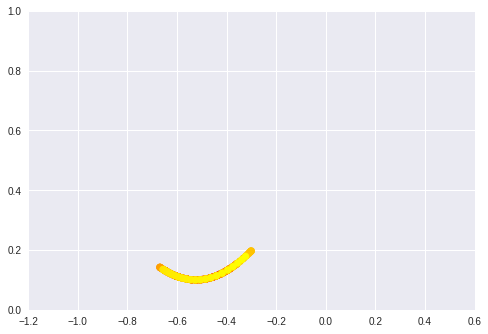

Total reward:  -199.0 
-----------
EPISODE  66
Mean batch loss per epoch:


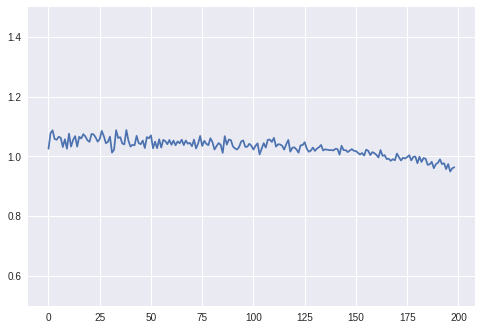

Cart position per epoch:


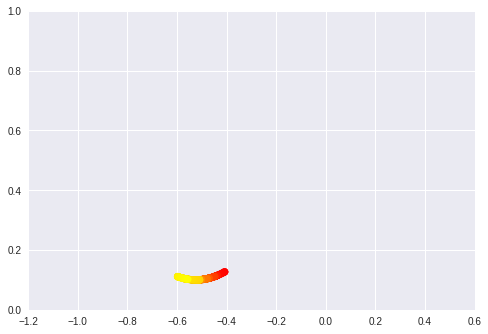

Total reward:  -199.0 
-----------
EPISODE  67
Mean batch loss per epoch:


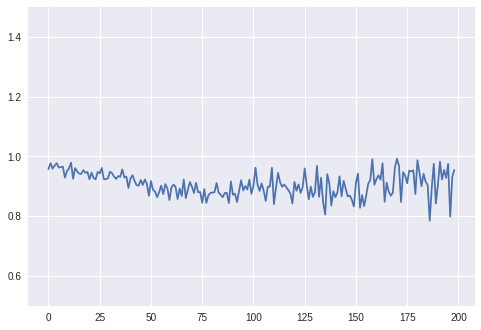

Cart position per epoch:


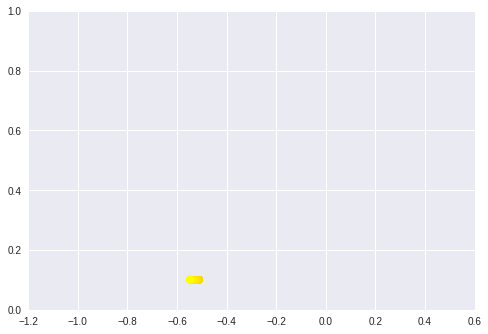

Total reward:  -199.0 
-----------
EPISODE  68
Mean batch loss per epoch:


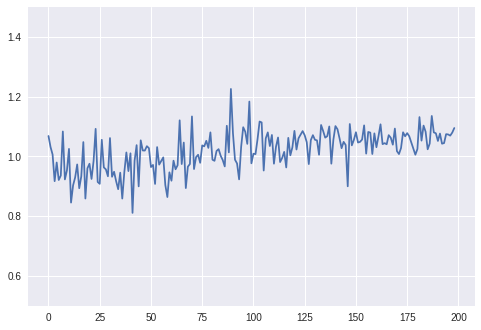

Cart position per epoch:


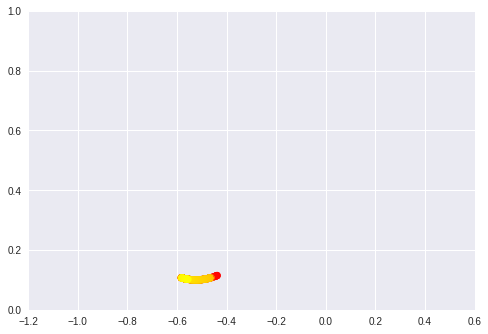

Total reward:  -199.0 
-----------
EPISODE  69
Mean batch loss per epoch:


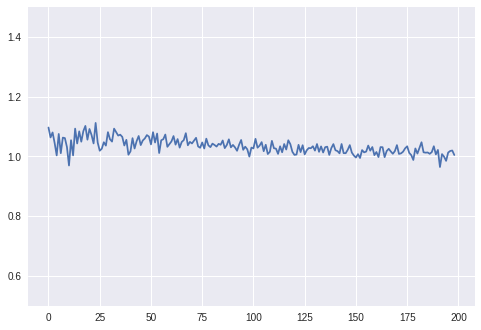

Cart position per epoch:


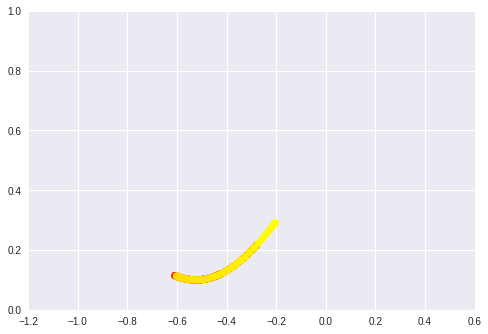

Total reward:  -199.0 
-----------
EPISODE  70
Mean batch loss per epoch:


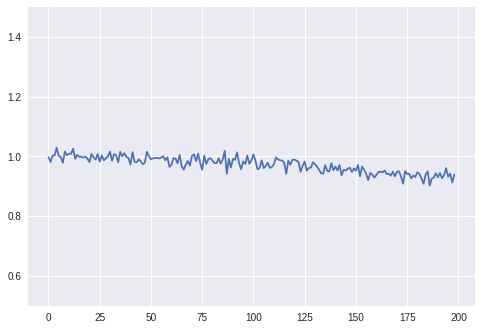

Cart position per epoch:


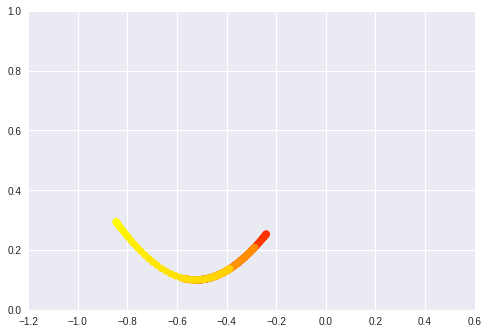

Total reward:  -199.0 
-----------
EPISODE  71
Mean batch loss per epoch:


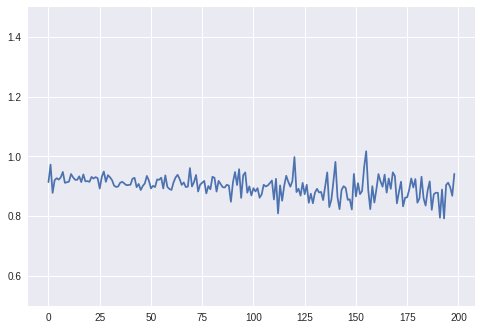

Cart position per epoch:


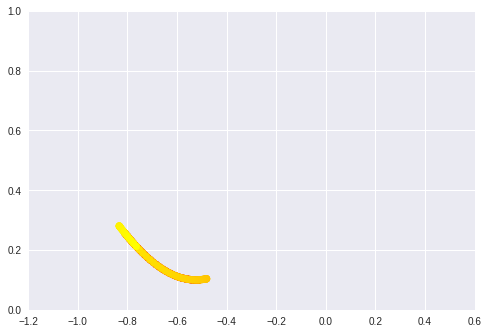

Total reward:  -199.0 
-----------
EPISODE  72
Mean batch loss per epoch:


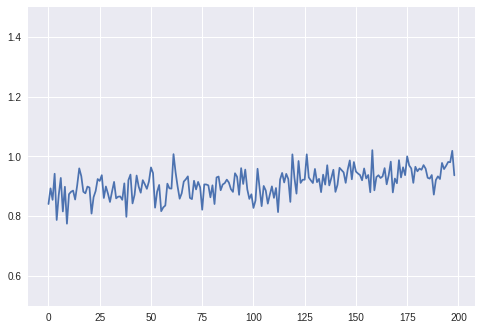

Cart position per epoch:


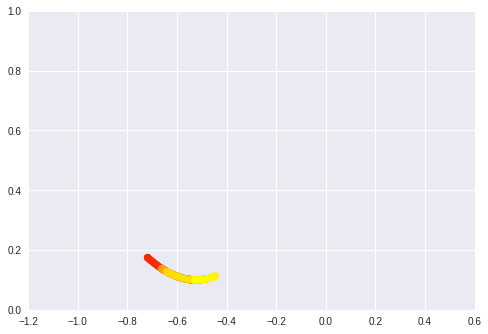

Total reward:  -199.0 
-----------
EPISODE  73
Mean batch loss per epoch:


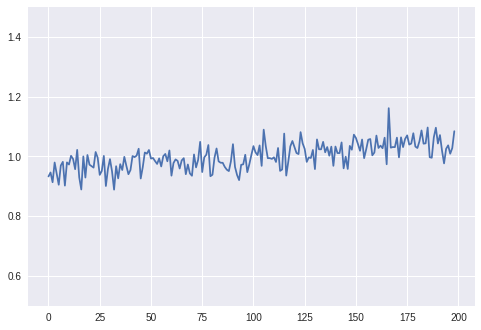

Cart position per epoch:


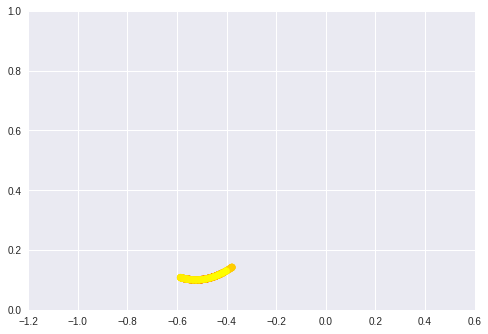

Total reward:  -199.0 
-----------
EPISODE  74


In [0]:
main()

## Bummer!

Okay, great. So we ran it overnight and it never managed to get out of the ditch. I found a great article [here](https://medium.com/ml-everything/reinforcement-learning-with-sparse-rewards-8f15b71d18bf) that does a great job of describing this phenomenon. We got all the math just right, and yet the learner just won't do anything interesting. This is a good time to step back, breathe, and try to work up some self-acceptance for not understanding all of AI right away.

Well, one big thing is that I initially forgot to actually pass the actor's parameters into the SGD optimizer that's supposed to train it. If you don't do this, the parameters never update and you're definitely going to stay stuck. Remember to keep track of your graph!

So suppose we are getting a constant stream of reward equal to -199.0. (This is what happened to me, and I assume it's running the same for you.) At first, I looked at the source code for the OpenAI environment hoping to see that the runtime gets capped at 200 steps. This is not the case. Instead, the cart gets initialized at a point $x_0 \in [-0.6, -0.4]$ and the code terminates only when it has reached $x \geq 0.5$. So why is it getting stuck at -199.0 every time?

Is it getting there randomly and not learning? I tried different random seeds and they still yield the same result. Next it's time to see if the neural net is actually learning. To do this, I tried to get [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) working, but of course it's not easy to use in Colab. Turns out matplotlib does fine.

Okay, after hacking through the MountainCar source code, I got matplotlib printing out trajectories in a somewhat readable way. We can now clearly see that the capping at 200 epochs is not a result of success. Additionally, after many hours of debugging, I did see a fluke: in one episode, the actor earned a reward of merely -171.0. Looking at the above plots, it's believable that the actor may well have actually solved the puzzle once.